In [3]:
import os, sys
from collections import defaultdict
from tqdm import tqdm
import time

In [4]:
import gymnasium as gym
import text_flappy_bird_gym
from flappy_bird_gymnasium import *
from tabulate import tabulate
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# env = gym.make('TextFlappyBird-screen-v0', height=15, width=20, pipe_gap=4)
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
env.reset()

((13, 2), {'score': 0, 'player': [6, 7], 'distance': 13.152946437965905})

In [132]:
class QLearningAgent():
    def __init__(self, num_actions,epsilon,eps_decay,step_size,step_size_decay,discount,seed):
        """Setup for the agent called when the experiment first starts.
        
        Args:
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            eps_decay (float): The decay rate of the epsilon parameter,
            step_size (float): The step-size,
            step_size_decay (float): The decay rate of the step-size parameter,
            discount (float): The discount factor
        
        """
        self.num_actions = num_actions
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.step_size = step_size
        self.step_size_decay = step_size_decay
        self.discount = discount
        self.rand_generator = np.random.RandomState(seed)
        
        # Create a dictionary for action-value estimates
        self.q = defaultdict(lambda: 0)

    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """

        # Set an array that will store the current q_values
        current_q =  [self.q[(state, 0)], self.q[(state, 1)]]

        # Choose action using epsilon greedy.
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions) # random action selection
        else:
            action = self.argmax(current_q) # greedy action selection

        self.prev_state = state
        self.prev_action = action

        return action


    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the environment's step based on where the agent ended up after the last step.
        Returns:
            action (int): the action the agent is taking.
        """

        # Set an array that will store the current q_values
        current_q =  [self.q[(state, 0)], self.q[(state, 1)]]

        # Choose action using epsilon greedy.
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions) # random action selection
        else:
            action = self.argmax(current_q) # greedy action selection

        # Perform an update
        self.q[(self.prev_state, self.prev_action)] += self.step_size * (reward + self.discount * np.max(current_q) - self.q[(self.prev_state, self.prev_action)])    


        # Decay for the step-size
        if self.step_size > 0.1:
                self.step_size = max(self.step_size * self.step_size_decay, 0.1) 

        # Decay for the epsilon
        if self.epsilon > 0.0001:
                self.epsilon = max(self.epsilon * self.eps_decay, 0.0001) 
        
        self.prev_state = state
        self.prev_action = action
        return action
    

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
            state(int):the state from the environment's step based on where the agent ended up after the
                last step.
        """
        # Perform the last update in the episode
        self.q[(self.prev_state, self.prev_action)] += self.step_size * (reward - self.q[(self.prev_state, self.prev_action)])     
        

    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)
    
    def train(self, env, num_episodes):
        """Train the agent (include both exploration and exploitation)
        Args:
            env (gym.env): the environment
            num_episodes (int): the number of episodes to train the agent on
            
        Returns:
            rewards (list): list of the sum of rewards obtained for each episode
            scores (list) : list of the scores obtained for each episode
        """
        rewards = []
        scores = []
        for episode in tqdm(range(num_episodes)):
            episode_rewards = 0
            state, _ = env.reset()
            if episode ==0:
                action = self.agent_start(state)
            else:
                while True:
                    next_state, reward, done, _, info = env.step(action)
                    next_action = self.agent_step(reward, next_state)
                    episode_rewards += reward
                    if done:
                        self.agent_end(reward)
                        break
                    state = next_state
                    action = next_action
                rewards.append(episode_rewards)
                scores.append(info['score'])
        return rewards, scores


    def test(self, env, n_episodes):
        """Test the agent (include only exploitation)
        Args:
            env (gym.env): the environment
            num_episodes (int): the number of episodes to test the agent on
            
        Returns:
            rewards (list): list of the sum of rewards obtained for each episode
            scores (list): list of the scores obtained for each episode
        """
        rewards = []
        scores = []
        for episode in tqdm(range(n_episodes)):
            episode_rewards = 0
            state, _ = env.reset()
            while True:
                q_values = [self.q[(state, 0)], self.q[(state, 1)]]
                action = self.argmax(q_values)
                next_state, reward, done, _, info = env.step(action)
                episode_rewards += reward
                if done:
                    break
                state = next_state
                if info['score'] >1e5: #Stopping condition to avoid it to be stuck if it never dies
                    break
            rewards.append(episode_rewards)
            scores.append(info['score'])
        return rewards, scores
    def run(self, env):
        state,_ = env.reset()
        done = False
        episode_reward = 0
        while not done:
            action = np.argmax([self.q[state,0], self.q[state,1]])
            next_state, reward,done,_, info = env.step(action)
            episode_reward += reward
            state = next_state
            if info['score'] >1e2: #Stopping condition to avoid it to be stuck if it never dies
                break
            os.system("clear")
            sys.stdout.write(env.render())
            time.sleep(0.1) # FPS
        return info['score']

In [133]:
class SARSAAgent():
    def __init__(self, num_actions,epsilon,eps_decay,lr,discount,seed):
        self.num_actions = num_actions
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.lr = lr
        self.discount = discount
        self.rand_generator = np.random.RandomState(seed)
        self.Q = defaultdict(lambda: 0)
        
        self.pre_state = 0
        self.pre_action = 0
    
    def argmax(self, q_values):
        top = float('-inf')
        ties = []
        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = [i]
            if q_values[i] == top:
                ties.append(i)
        return self.rand_generator.choice(ties)

    def agent_start(self, state):
        current_q = [self.Q[state, 0], self.Q[state, 1]]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        self.pre_state = state
        self.pre_action = action
        return action

    def agent_step(self, reward, state, episode, num_episodes):
        current_q = [self.Q[state, 0], self.Q[state, 1]]
        
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
            
        predict = self.Q[self.pre_state, self.pre_action]
        target = reward + self.discount * self.Q[state, action]
        
        self.Q[self.pre_state, self.pre_action] += self.lr*(target - predict)
            
        self.pre_state = state
        self.pre_action = action
        return action

    def agent_end(self, reward):
        self.Q[self.pre_state, self.pre_action] += self.lr * (reward - self.Q[self.pre_state, self.pre_action])
        

    def train(self, env, num_episodes):
        # self.num_episodes = num_episodes
        scores = []
        awards = []
        for episode in tqdm(range(num_episodes)):
            episode_rewards = 0
            state, _ = env.reset()
            if episode == 0:
                action = self.agent_start(state)
            else:
                while True:
                    next_state, reward, done, _, info = env.step(action)
                    next_action = self.agent_step(reward, next_state, episode, num_episodes)
                    episode_rewards += reward
                    if done:
                        self.agent_end(reward)
                        break
                    state = next_state
                    action = next_action
                scores.append(info['score'])
                awards.append(episode_rewards)
            self.epsilon = max(self.epsilon * self.eps_decay, 0.005)
        return np.array(awards), np.array(scores)

    def test(self, env, n_episodes):
        scores=[]
        for i in tqdm(range(n_episodes)):
            state,_ = env.reset()
            done = False
            while not done:
                action = np.argmax([self.Q[state,0], self.Q[state,1]])
                next_state, reward,done,_, info = env.step(action)
                state = next_state
                if info['score'] >1e2: #Stopping condition to avoid it to be stuck if it never dies
                    break
            scores.append(info['score'])
        return np.array(scores)

    def run(self, env):
        state,_ = env.reset()
        done = False
        episode_reward = 0
        while not done:
            action = np.argmax([self.Q[state,0], self.Q[state,1]])
            next_state, reward,done,_, info = env.step(action)
            episode_reward += reward
            state = next_state
            if info['score'] >1e2: #Stopping condition to avoid it to be stuck if it never dies
                break
            os.system("clear")
            sys.stdout.write(env.render())
            time.sleep(0.2) # FPS
        return info['score']

In [37]:
class MonteCarlo:
    def __init__(self, gamma, epsilon=0.1):
        """
        Initialize the Monte Carlo agent.

        Args:
            env (gym.Env): The environment to use.
            gamma (float): The discount factor.
            n_episodes (int): The number of episodes to train for.
            epsilon (float): The probability of selecting a random action.
        """
        
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = defaultdict(lambda: 0)
        self.N = defaultdict(lambda: 0)
    
    def choose_action(self, state):
        """
        Choose an action to take given a state.

        Args:
            state: The current state.

        Returns:
            The chosen action.
        """
        
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.randint(2)
        else:
            return np.argmax([self.Q[(state,0)],self.Q[(state,1)]])

    def update_Q(self, episode):
        """
        Update the Q values given an episode.

        Args:
            episode: The episode to use for updating.

        Returns:
            None.
        """
        
        G = 0
        visited = set()
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = self.gamma * G + reward
            if (state, action) not in visited:
                self.N[(state, action)] += 1
                self.Q[(state, action)] += (G - self.Q[state, action]) / self.N[state, action]
                visited.add((state, action))
    
    def train(self,env, n_episodes):
        """Train the agent (include both exploration and exploitation)
        Args:
            env (gym.env): the environment
            num_episodes (int): the number of episodes to train the agent on
            
        Returns:
            rewards (list): list of the sum of rewards obtained for each episode
            scores (list) : list of the scores obtained for each episode
        """
        rewards = []
        scores=[]
        for i in tqdm(range(n_episodes)):
            state,_ = env.reset()
            done = False
            episode = []
            episode_reward = 0
            while not done:
                action = self.choose_action(state)
                next_state, reward,done,_, info = env.step(action)
                episode.append((state, action, reward))
                episode_reward += reward
                state = next_state
            self.update_Q(episode)
            rewards.append(episode_reward)
            scores.append(info['score'])
        return rewards,scores  
    
    def test(self,env, n_episodes):
        """Test the agent (include only exploitation)
        Args:
            env (gym.env): the environment
            num_episodes (int): the number of episodes to train the agent on
            
        Returns:
            rewards (list): list of the sum of rewards obtained for each episode
            scores (list): list of the scores obtained for each episode
        """
        rewards = []
        scores=[]
        for i in tqdm(range(n_episodes)):
            state,_ = env.reset()
            done = False
            episode_reward = 0
            while not done:
                action = np.argmax([self.Q[state,0],self.Q[state,1]])
                next_state, reward,done,_, info = env.step(action)
                episode_reward += reward
                state = next_state
                if info['score'] >1e5: #Stopping condition to avoid it to be stuck if it never dies
                    break
            rewards.append(episode_reward)
            scores.append(info['score'])
        return rewards,scores
    def run(self, env):
        state,_ = env.reset()
        done = False
        episode_reward = 0
        while not done:
            action = np.argmax([self.Q[state,0], self.Q[state,1]])
            next_state, reward,done,_, info = env.step(action)
            episode_reward += reward
            state = next_state
            if info['score'] >1e2: #Stopping condition to avoid it to be stuck if it never dies
                break
            os.system("clear")
            sys.stdout.write(env.render())
            time.sleep(0.2) # FPS
        return info['score']

In [53]:
Q_agent = QLearningAgent(num_actions=2,epsilon=0.1,eps_decay=1,step_size=0.7,step_size_decay=1,discount=1,seed=0)
SS_agent = SARSAAgent(num_actions=2,epsilon=0.1,eps_decay=1,lr=0.7,discount=1,seed=0)

n_episodes = 10000
train_rewards_Q, train_scores_Q = Q_agent.train(env,n_episodes)
train_rewards_SS, train_scores_SS = SS_agent.train(env, n_episodes)

window = 1000
average_reward_Q_dc100 = [np.mean(train_rewards_Q[:window])]*window
average_reward_SS_dc100 = [np.mean(train_rewards_SS[:window])]*window
average_score_Q_dc100 = [np.mean(train_scores_Q[:window])]*window
average_score_SS_dc100 = [np.mean(train_scores_SS[:window])]*window
for ind in range(len(train_scores_Q) - window + 1):    
    average_score_Q_dc100.append(np.mean(train_scores_Q[ind:ind+window]))
for ind in range(len(train_scores_SS) - window + 1):
    average_score_SS_dc100.append(np.mean(train_scores_SS[ind:ind+window]))
for ind in range(len(train_rewards_Q) - window + 1):    
    average_reward_Q_dc100.append(np.mean(train_rewards_Q[ind:ind+window]))
for ind in range(len(train_rewards_SS) - window + 1):
    average_reward_SS_dc100.append(np.mean(train_rewards_SS[ind:ind+window]))

100%|██████████| 10000/10000 [00:06<00:00, 1451.31it/s]


In [54]:
Q_agent = QLearningAgent(num_actions=2,epsilon=0.1,eps_decay=1,step_size=0.7,step_size_decay=1,discount=0.95,seed=0)
SS_agent = SARSAAgent(num_actions=2,epsilon=0.1,eps_decay=1,lr=0.7,discount=0.95,seed=0)

n_episodes = 10000
train_rewards_Q, train_scores_Q = Q_agent.train(env,n_episodes)
train_rewards_SS, train_scores_SS = SS_agent.train(env, n_episodes)

window = 1000
average_reward_Q_dc95 = [np.mean(train_rewards_Q[:window])]*window
average_reward_SS_dc95 = [np.mean(train_rewards_SS[:window])]*window
average_score_Q_dc95 = [np.mean(train_scores_Q[:window])]*window
average_score_SS_dc95 = [np.mean(train_scores_SS[:window])]*window
for ind in range(len(train_scores_Q) - window + 1):    
    average_score_Q_dc95.append(np.mean(train_scores_Q[ind:ind+window]))
for ind in range(len(train_scores_SS) - window + 1):
    average_score_SS_dc95.append(np.mean(train_scores_SS[ind:ind+window]))
for ind in range(len(train_rewards_Q) - window + 1):    
    average_reward_Q_dc95.append(np.mean(train_rewards_Q[ind:ind+window]))
for ind in range(len(train_rewards_SS) - window + 1):
    average_reward_SS_dc95.append(np.mean(train_rewards_SS[ind:ind+window]))

100%|██████████| 10000/10000 [00:10<00:00, 919.94it/s]


In [55]:
Q_agent = QLearningAgent(num_actions=2,epsilon=0.1,eps_decay=1,step_size=0.7,step_size_decay=1,discount=0.9,seed=0)
SS_agent = SARSAAgent(num_actions=2,epsilon=0.1,eps_decay=1,lr=0.7,discount=0.9,seed=0)

n_episodes = 10000
train_rewards_Q, train_scores_Q = Q_agent.train(env,n_episodes)
train_rewards_SS, train_scores_SS = SS_agent.train(env, n_episodes)

window = 1000
average_reward_Q_dc90 = [np.mean(train_rewards_Q[:window])]*window
average_reward_SS_dc90 = [np.mean(train_rewards_SS[:window])]*window
average_score_Q_dc90 = [np.mean(train_scores_Q[:window])]*window
average_score_SS_dc90 = [np.mean(train_scores_SS[:window])]*window
for ind in range(len(train_scores_Q) - window + 1):    
    average_score_Q_dc90.append(np.mean(train_scores_Q[ind:ind+window]))
for ind in range(len(train_scores_SS) - window + 1):
    average_score_SS_dc90.append(np.mean(train_scores_SS[ind:ind+window]))
for ind in range(len(train_rewards_Q) - window + 1):    
    average_reward_Q_dc90.append(np.mean(train_rewards_Q[ind:ind+window]))
for ind in range(len(train_rewards_SS) - window + 1):
    average_reward_SS_dc90.append(np.mean(train_rewards_SS[ind:ind+window]))

100%|██████████| 10000/10000 [00:08<00:00, 1140.73it/s]


In [56]:
Q_agent = QLearningAgent(num_actions=2,epsilon=0.1,eps_decay=1,step_size=0.7,step_size_decay=1,discount=0.85,seed=0)
SS_agent = SARSAAgent(num_actions=2,epsilon=0.1,eps_decay=1,lr=0.7,discount=0.85,seed=0)

n_episodes = 10000
train_rewards_Q, train_scores_Q = Q_agent.train(env,n_episodes)
train_rewards_SS, train_scores_SS = SS_agent.train(env, n_episodes)

window = 1000
average_reward_Q_dc85 = [np.mean(train_rewards_Q[:window])]*window
average_reward_SS_dc85 = [np.mean(train_rewards_SS[:window])]*window
average_score_Q_dc85 = [np.mean(train_scores_Q[:window])]*window
average_score_SS_dc85 = [np.mean(train_scores_SS[:window])]*window
for ind in range(len(train_scores_Q) - window + 1):    
    average_score_Q_dc85.append(np.mean(train_scores_Q[ind:ind+window]))
for ind in range(len(train_scores_SS) - window + 1):
    average_score_SS_dc85.append(np.mean(train_scores_SS[ind:ind+window]))
for ind in range(len(train_rewards_Q) - window + 1):    
    average_reward_Q_dc85.append(np.mean(train_rewards_Q[ind:ind+window]))
for ind in range(len(train_rewards_SS) - window + 1):
    average_reward_SS_dc85.append(np.mean(train_rewards_SS[ind:ind+window]))

100%|██████████| 10000/10000 [00:08<00:00, 1119.35it/s]


In [57]:
Q_agent = QLearningAgent(num_actions=2,epsilon=0.1,eps_decay=1,step_size=0.7,step_size_decay=1,discount=0.8,seed=0)
SS_agent = SARSAAgent(num_actions=2,epsilon=0.1,eps_decay=1,lr=0.7,discount=0.8,seed=0)

n_episodes = 10000
train_rewards_Q, train_scores_Q = Q_agent.train(env,n_episodes)
train_rewards_SS, train_scores_SS = SS_agent.train(env, n_episodes)

window = 1000
average_reward_Q_dc80 = [np.mean(train_rewards_Q[:window])]*window
average_reward_SS_dc80 = [np.mean(train_rewards_SS[:window])]*window
average_score_Q_dc80 = [np.mean(train_scores_Q[:window])]*window
average_score_SS_dc80 = [np.mean(train_scores_SS[:window])]*window
for ind in range(len(train_scores_Q) - window + 1):    
    average_score_Q_dc80.append(np.mean(train_scores_Q[ind:ind+window]))
for ind in range(len(train_scores_SS) - window + 1):
    average_score_SS_dc80.append(np.mean(train_scores_SS[ind:ind+window]))
for ind in range(len(train_rewards_Q) - window + 1):    
    average_reward_Q_dc80.append(np.mean(train_rewards_Q[ind:ind+window]))
for ind in range(len(train_rewards_SS) - window + 1):
    average_reward_SS_dc80.append(np.mean(train_rewards_SS[ind:ind+window]))

100%|██████████| 10000/10000 [00:09<00:00, 1075.20it/s]


In [58]:
Q_agent = QLearningAgent(num_actions=2,epsilon=0.1,eps_decay=1,step_size=0.7,step_size_decay=1,discount=0.75,seed=0)
SS_agent = SARSAAgent(num_actions=2,epsilon=0.1,eps_decay=1,lr=0.7,discount=0.75,seed=0)

n_episodes = 10000
train_rewards_Q, train_scores_Q = Q_agent.train(env,n_episodes)
train_rewards_SS, train_scores_SS = SS_agent.train(env, n_episodes)

window = 1000
average_reward_Q_dc75 = [np.mean(train_rewards_Q[:window])]*window
average_reward_SS_dc75 = [np.mean(train_rewards_SS[:window])]*window
average_score_Q_dc75 = [np.mean(train_scores_Q[:window])]*window
average_score_SS_dc75 = [np.mean(train_scores_SS[:window])]*window
for ind in range(len(train_scores_Q) - window + 1):    
    average_score_Q_dc75.append(np.mean(train_scores_Q[ind:ind+window]))
for ind in range(len(train_scores_SS) - window + 1):
    average_score_SS_dc75.append(np.mean(train_scores_SS[ind:ind+window]))
for ind in range(len(train_rewards_Q) - window + 1):    
    average_reward_Q_dc75.append(np.mean(train_rewards_Q[ind:ind+window]))
for ind in range(len(train_rewards_SS) - window + 1):
    average_reward_SS_dc75.append(np.mean(train_rewards_SS[ind:ind+window]))

100%|██████████| 10000/10000 [00:10<00:00, 988.00it/s]


In [59]:
Q_agent = QLearningAgent(num_actions=2,epsilon=0.1,eps_decay=1,step_size=0.7,step_size_decay=1,discount=0.7,seed=0)
SS_agent = SARSAAgent(num_actions=2,epsilon=0.1,eps_decay=1,lr=0.7,discount=0.7,seed=0)

n_episodes = 10000
train_rewards_Q, train_scores_Q = Q_agent.train(env,n_episodes)
train_rewards_SS, train_scores_SS = SS_agent.train(env, n_episodes)

window = 1000
average_reward_Q_dc70 = [np.mean(train_rewards_Q[:window])]*window
average_reward_SS_dc70 = [np.mean(train_rewards_SS[:window])]*window
average_score_Q_dc70 = [np.mean(train_scores_Q[:window])]*window
average_score_SS_dc70 = [np.mean(train_scores_SS[:window])]*window
for ind in range(len(train_scores_Q) - window + 1):    
    average_score_Q_dc70.append(np.mean(train_scores_Q[ind:ind+window]))
for ind in range(len(train_scores_SS) - window + 1):
    average_score_SS_dc70.append(np.mean(train_scores_SS[ind:ind+window]))
for ind in range(len(train_rewards_Q) - window + 1):    
    average_reward_Q_dc70.append(np.mean(train_rewards_Q[ind:ind+window]))
for ind in range(len(train_rewards_SS) - window + 1):
    average_reward_SS_dc70.append(np.mean(train_rewards_SS[ind:ind+window]))

100%|██████████| 10000/10000 [00:12<00:00, 792.42it/s]


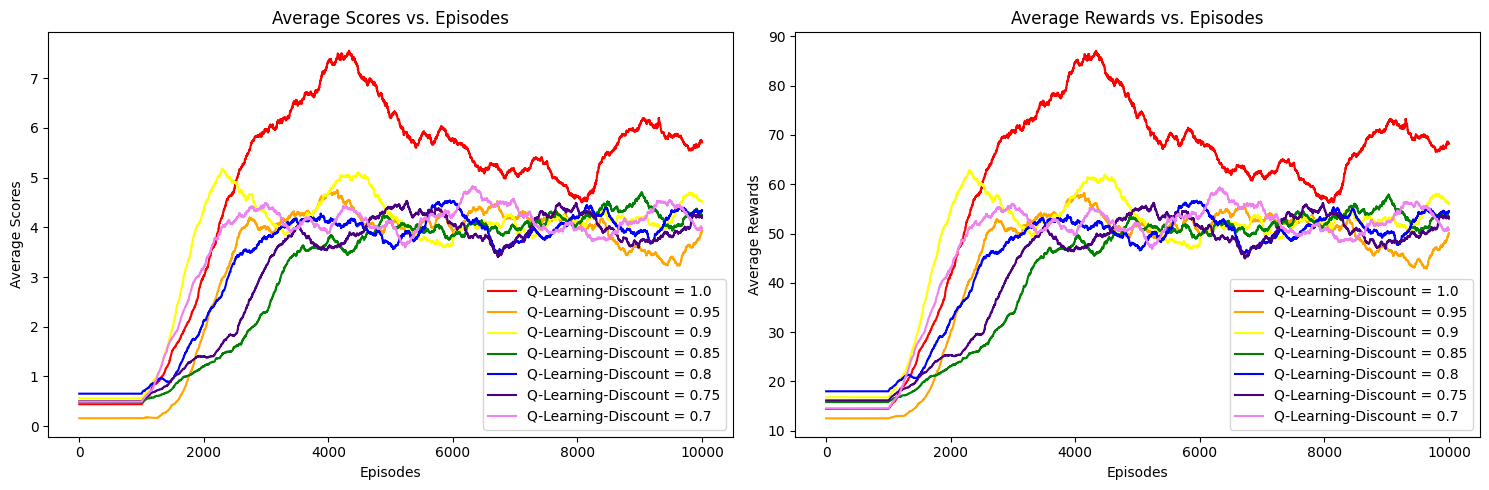

In [101]:
episodes = np.arange(0, 10000, 1)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5)) 

# Đồ thị đầu tiên cho Average Scores
ax1.plot(episodes, average_score_Q_dc100, label="Q-Learning-Discount = 1.0", color="red")
ax1.plot(episodes, average_score_Q_dc95, label="Q-Learning-Discount = 0.95", color="orange")
ax1.plot(episodes, average_score_Q_dc90, label="Q-Learning-Discount = 0.9", color="yellow")
ax1.plot(episodes, average_score_Q_dc85, label="Q-Learning-Discount = 0.85", color="green")
ax1.plot(episodes, average_score_Q_dc80, label="Q-Learning-Discount = 0.8", color="blue")
ax1.plot(episodes, average_score_Q_dc75, label="Q-Learning-Discount = 0.75", color="indigo")
ax1.plot(episodes, average_score_Q_dc70, label="Q-Learning-Discount = 0.7", color="violet")
ax1.set_xlabel("Episodes")
ax1.set_ylabel("Average Scores")
ax1.legend()
ax1.set_title("Average Scores vs. Episodes")

# Đồ thị thứ hai cho Average Rewards
ax2.plot(episodes, average_reward_Q_dc100, label="Q-Learning-Discount = 1.0", color="red")
ax2.plot(episodes, average_reward_Q_dc95, label="Q-Learning-Discount = 0.95", color="orange")
ax2.plot(episodes, average_reward_Q_dc90, label="Q-Learning-Discount = 0.9", color="yellow")
ax2.plot(episodes, average_reward_Q_dc85, label="Q-Learning-Discount = 0.85", color="green")
ax2.plot(episodes, average_reward_Q_dc80, label="Q-Learning-Discount = 0.8", color="blue")
ax2.plot(episodes, average_reward_Q_dc75, label="Q-Learning-Discount = 0.75", color="indigo")
ax2.plot(episodes, average_reward_Q_dc70, label="Q-Learning-Discount = 0.7", color="violet")
ax2.set_xlabel("Episodes")
ax2.set_ylabel("Average Rewards")
ax2.legend()
ax2.set_title("Average Rewards vs. Episodes")

# Hiển thị cả hai đồ thị trong cùng một khung hình
plt.tight_layout()  # Điều chỉnh khoảng cách giữa các đồ thị
plt.show()


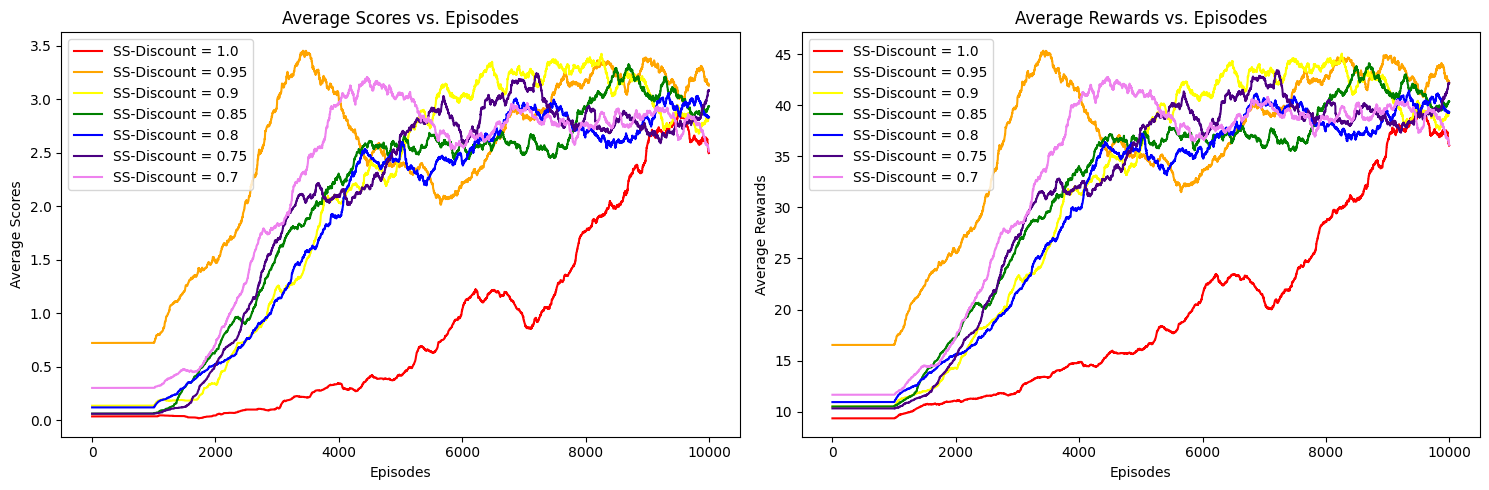

In [102]:
episodes = np.arange(0, 10000, 1)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5)) 

# Đồ thị đầu tiên cho Average Scores
ax1.plot(episodes, average_score_SS_dc100, label="SS-Discount = 1.0", color="red")
ax1.plot(episodes, average_score_SS_dc95, label="SS-Discount = 0.95", color="orange")
ax1.plot(episodes, average_score_SS_dc90, label="SS-Discount = 0.9", color="yellow")
ax1.plot(episodes, average_score_SS_dc85, label="SS-Discount = 0.85", color="green")
ax1.plot(episodes, average_score_SS_dc80, label="SS-Discount = 0.8", color="blue")
ax1.plot(episodes, average_score_SS_dc75, label="SS-Discount = 0.75", color="indigo")
ax1.plot(episodes, average_score_SS_dc70, label="SS-Discount = 0.7", color="violet")
ax1.set_xlabel("Episodes")
ax1.set_ylabel("Average Scores")
ax1.legend()
ax1.set_title("Average Scores vs. Episodes")

# Đồ thị thứ hai cho Average Rewards
ax2.plot(episodes, average_reward_SS_dc100, label="SS-Discount = 1.0", color="red")
ax2.plot(episodes, average_reward_SS_dc95, label="SS-Discount = 0.95", color="orange")
ax2.plot(episodes, average_reward_SS_dc90, label="SS-Discount = 0.9", color="yellow")
ax2.plot(episodes, average_reward_SS_dc85, label="SS-Discount = 0.85", color="green")
ax2.plot(episodes, average_reward_SS_dc80, label="SS-Discount = 0.8", color="blue")
ax2.plot(episodes, average_reward_SS_dc75, label="SS-Discount = 0.75", color="indigo")
ax2.plot(episodes, average_reward_SS_dc70, label="SS-Discount = 0.7", color="violet")
ax2.set_xlabel("Episodes")
ax2.set_ylabel("Average Rewards")
ax2.legend()
ax2.set_title("Average Rewards vs. Episodes")

# Hiển thị cả hai đồ thị trong cùng một khung hình
plt.tight_layout()  # Điều chỉnh khoảng cách giữa các đồ thị
plt.show()

In [63]:
Q_agent = QLearningAgent(num_actions=2,epsilon=0.05,eps_decay=1,step_size=0.7,step_size_decay=1,discount=1,seed=0)
SS_agent = SARSAAgent(num_actions=2,epsilon=0.05,eps_decay=1,lr=0.7,discount=1,seed=0)

n_episodes = 10000
train_rewards_Q, train_scores_Q = Q_agent.train(env,n_episodes)
train_rewards_SS, train_scores_SS = SS_agent.train(env, n_episodes)

window = 1000
average_reward_Q_eps005 = [np.mean(train_rewards_Q[:window])]*window
average_reward_SS_eps005 = [np.mean(train_rewards_SS[:window])]*window
average_score_Q_eps005 = [np.mean(train_scores_Q[:window])]*window
average_score_SS_eps005 = [np.mean(train_scores_SS[:window])]*window
for ind in range(len(train_scores_Q) - window + 1):    
    average_score_Q_eps005.append(np.mean(train_scores_Q[ind:ind+window]))
for ind in range(len(train_scores_SS) - window + 1):
    average_score_SS_eps005.append(np.mean(train_scores_SS[ind:ind+window]))
for ind in range(len(train_rewards_Q) - window + 1):    
    average_reward_Q_eps005.append(np.mean(train_rewards_Q[ind:ind+window]))
for ind in range(len(train_rewards_SS) - window + 1):
    average_reward_SS_eps005.append(np.mean(train_rewards_SS[ind:ind+window]))

100%|██████████| 10000/10000 [00:07<00:00, 1271.72it/s]


In [64]:
Q_agent = QLearningAgent(num_actions=2,epsilon=0.1,eps_decay=1,step_size=0.7,step_size_decay=1,discount=1,seed=0)
SS_agent = SARSAAgent(num_actions=2,epsilon=0.1,eps_decay=1,lr=0.7,discount=1,seed=0)

n_episodes = 10000
train_rewards_Q, train_scores_Q = Q_agent.train(env,n_episodes)
train_rewards_SS, train_scores_SS = SS_agent.train(env, n_episodes)

window = 1000
average_reward_Q_eps01 = [np.mean(train_rewards_Q[:window])]*window
average_reward_SS_eps01 = [np.mean(train_rewards_SS[:window])]*window
average_score_Q_eps01 = [np.mean(train_scores_Q[:window])]*window
average_score_SS_eps01 = [np.mean(train_scores_SS[:window])]*window
for ind in range(len(train_scores_Q) - window + 1):    
    average_score_Q_eps01.append(np.mean(train_scores_Q[ind:ind+window]))
for ind in range(len(train_scores_SS) - window + 1):
    average_score_SS_eps01.append(np.mean(train_scores_SS[ind:ind+window]))
for ind in range(len(train_rewards_Q) - window + 1):    
    average_reward_Q_eps01.append(np.mean(train_rewards_Q[ind:ind+window]))
for ind in range(len(train_rewards_SS) - window + 1):
    average_reward_SS_eps01.append(np.mean(train_rewards_SS[ind:ind+window]))

100%|██████████| 10000/10000 [00:10<00:00, 997.94it/s]


In [65]:
Q_agent = QLearningAgent(num_actions=2,epsilon=0.15,eps_decay=1,step_size=0.7,step_size_decay=1,discount=1,seed=0)
SS_agent = SARSAAgent(num_actions=2,epsilon=0.15,eps_decay=1,lr=0.7,discount=1,seed=0)

n_episodes = 10000
train_rewards_Q, train_scores_Q = Q_agent.train(env,n_episodes)
train_rewards_SS, train_scores_SS = SS_agent.train(env, n_episodes)

window = 1000
average_reward_Q_eps015 = [np.mean(train_rewards_Q[:window])]*window
average_reward_SS_eps015 = [np.mean(train_rewards_SS[:window])]*window
average_score_Q_eps015 = [np.mean(train_scores_Q[:window])]*window
average_score_SS_eps015 = [np.mean(train_scores_SS[:window])]*window
for ind in range(len(train_scores_Q) - window + 1):    
    average_score_Q_eps015.append(np.mean(train_scores_Q[ind:ind+window]))
for ind in range(len(train_scores_SS) - window + 1):
    average_score_SS_eps015.append(np.mean(train_scores_SS[ind:ind+window]))
for ind in range(len(train_rewards_Q) - window + 1):    
    average_reward_Q_eps015.append(np.mean(train_rewards_Q[ind:ind+window]))
for ind in range(len(train_rewards_SS) - window + 1):
    average_reward_SS_eps015.append(np.mean(train_rewards_SS[ind:ind+window]))

100%|██████████| 10000/10000 [00:09<00:00, 1030.64it/s]


In [66]:
Q_agent = QLearningAgent(num_actions=2,epsilon=0.2,eps_decay=1,step_size=0.7,step_size_decay=1,discount=1,seed=0)
SS_agent = SARSAAgent(num_actions=2,epsilon=0.2,eps_decay=1,lr=0.7,discount=1,seed=0)

n_episodes = 10000
train_rewards_Q, train_scores_Q = Q_agent.train(env,n_episodes)
train_rewards_SS, train_scores_SS = SS_agent.train(env, n_episodes)

window = 1000
average_reward_Q_eps020 = [np.mean(train_rewards_Q[:window])]*window
average_reward_SS_eps020 = [np.mean(train_rewards_SS[:window])]*window
average_score_Q_eps020 = [np.mean(train_scores_Q[:window])]*window
average_score_SS_eps020 = [np.mean(train_scores_SS[:window])]*window
for ind in range(len(train_scores_Q) - window + 1):    
    average_score_Q_eps020.append(np.mean(train_scores_Q[ind:ind+window]))
for ind in range(len(train_scores_SS) - window + 1):
    average_score_SS_eps020.append(np.mean(train_scores_SS[ind:ind+window]))
for ind in range(len(train_rewards_Q) - window + 1):    
    average_reward_Q_eps020.append(np.mean(train_rewards_Q[ind:ind+window]))
for ind in range(len(train_rewards_SS) - window + 1):
    average_reward_SS_eps020.append(np.mean(train_rewards_SS[ind:ind+window]))

100%|██████████| 10000/10000 [00:06<00:00, 1604.73it/s]


In [67]:
Q_agent = QLearningAgent(num_actions=2,epsilon=0.25,eps_decay=1,step_size=0.7,step_size_decay=1,discount=1,seed=0)
SS_agent = SARSAAgent(num_actions=2,epsilon=0.25,eps_decay=1,lr=0.7,discount=1,seed=0)

n_episodes = 10000
train_rewards_Q, train_scores_Q = Q_agent.train(env,n_episodes)
train_rewards_SS, train_scores_SS = SS_agent.train(env, n_episodes)

window = 1000
average_reward_Q_eps025 = [np.mean(train_rewards_Q[:window])]*window
average_reward_SS_eps025 = [np.mean(train_rewards_SS[:window])]*window
average_score_Q_eps025 = [np.mean(train_scores_Q[:window])]*window
average_score_SS_eps025 = [np.mean(train_scores_SS[:window])]*window
for ind in range(len(train_scores_Q) - window + 1):    
    average_score_Q_eps025.append(np.mean(train_scores_Q[ind:ind+window]))
for ind in range(len(train_scores_SS) - window + 1):
    average_score_SS_eps025.append(np.mean(train_scores_SS[ind:ind+window]))
for ind in range(len(train_rewards_Q) - window + 1):    
    average_reward_Q_eps025.append(np.mean(train_rewards_Q[ind:ind+window]))
for ind in range(len(train_rewards_SS) - window + 1):
    average_reward_SS_eps025.append(np.mean(train_rewards_SS[ind:ind+window]))

100%|██████████| 10000/10000 [00:05<00:00, 1677.03it/s]


In [68]:
Q_agent = QLearningAgent(num_actions=2,epsilon=0.3,eps_decay=1,step_size=0.7,step_size_decay=1,discount=1,seed=0)
SS_agent = SARSAAgent(num_actions=2,epsilon=0.3,eps_decay=1,lr=0.7,discount=1,seed=0)

n_episodes = 10000
train_rewards_Q, train_scores_Q = Q_agent.train(env,n_episodes)
train_rewards_SS, train_scores_SS = SS_agent.train(env, n_episodes)

window = 1000
average_reward_Q_eps030 = [np.mean(train_rewards_Q[:window])]*window
average_reward_SS_eps030 = [np.mean(train_rewards_SS[:window])]*window
average_score_Q_eps030 = [np.mean(train_scores_Q[:window])]*window
average_score_SS_eps030 = [np.mean(train_scores_SS[:window])]*window
for ind in range(len(train_scores_Q) - window + 1):    
    average_score_Q_eps030.append(np.mean(train_scores_Q[ind:ind+window]))
for ind in range(len(train_scores_SS) - window + 1):
    average_score_SS_eps030.append(np.mean(train_scores_SS[ind:ind+window]))
for ind in range(len(train_rewards_Q) - window + 1):    
    average_reward_Q_eps030.append(np.mean(train_rewards_Q[ind:ind+window]))
for ind in range(len(train_rewards_SS) - window + 1):
    average_reward_SS_eps030.append(np.mean(train_rewards_SS[ind:ind+window]))

100%|██████████| 10000/10000 [00:07<00:00, 1373.22it/s]


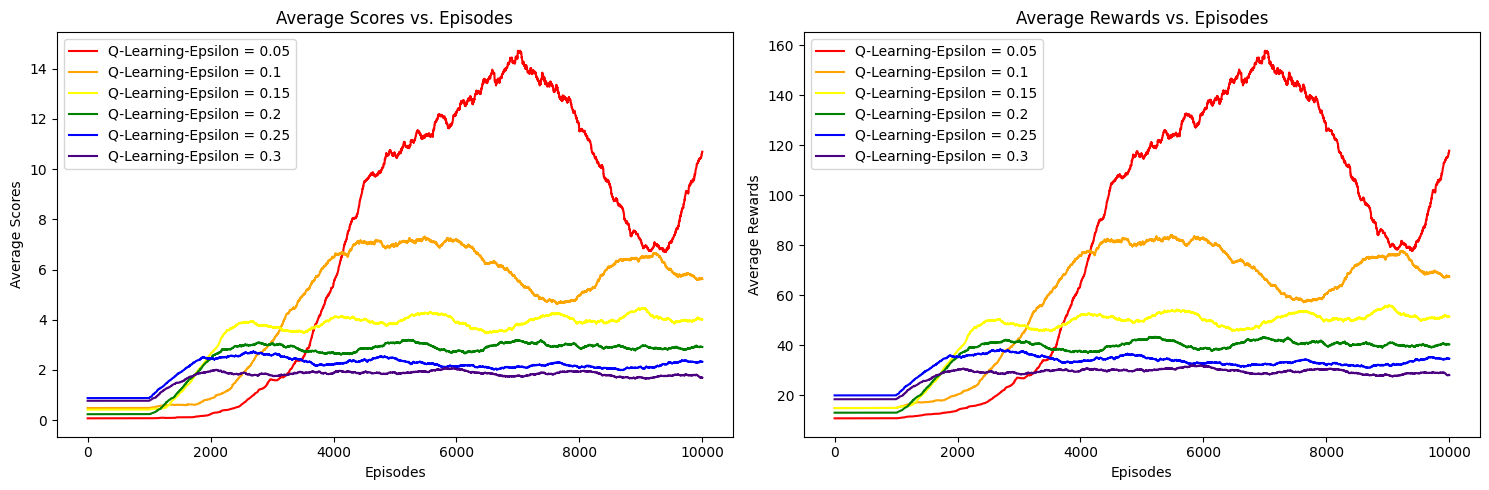

In [103]:
episodes = np.arange(0, 10000, 1)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5)) 

# Đồ thị đầu tiên cho Average Scores
ax1.plot(episodes, average_score_Q_eps005, label="Q-Learning-Epsilon = 0.05", color="red")
ax1.plot(episodes, average_score_Q_eps01, label="Q-Learning-Epsilon = 0.1", color="orange")
ax1.plot(episodes, average_score_Q_eps015, label="Q-Learning-Epsilon = 0.15", color="yellow")
ax1.plot(episodes, average_score_Q_eps020, label="Q-Learning-Epsilon = 0.2", color="green")
ax1.plot(episodes, average_score_Q_eps025, label="Q-Learning-Epsilon = 0.25", color="blue")
ax1.plot(episodes, average_score_Q_eps030, label="Q-Learning-Epsilon = 0.3", color="indigo")
ax1.set_xlabel("Episodes")
ax1.set_ylabel("Average Scores")
ax1.legend()
ax1.set_title("Average Scores vs. Episodes")

# Đồ thị thứ hai cho Average Rewards
ax2.plot(episodes, average_reward_Q_eps005, label="Q-Learning-Epsilon = 0.05", color="red")
ax2.plot(episodes, average_reward_Q_eps01, label="Q-Learning-Epsilon = 0.1", color="orange")
ax2.plot(episodes, average_reward_Q_eps015, label="Q-Learning-Epsilon = 0.15", color="yellow")
ax2.plot(episodes, average_reward_Q_eps020, label="Q-Learning-Epsilon = 0.2", color="green")
ax2.plot(episodes, average_reward_Q_eps025, label="Q-Learning-Epsilon = 0.25", color="blue")
ax2.plot(episodes, average_reward_Q_eps030, label="Q-Learning-Epsilon = 0.3", color="indigo")
ax2.set_xlabel("Episodes")
ax2.set_ylabel("Average Rewards")
ax2.legend()
ax2.set_title("Average Rewards vs. Episodes")

# Hiển thị cả hai đồ thị trong cùng một khung hình
plt.tight_layout()  # Điều chỉnh khoảng cách giữa các đồ thị
plt.show()


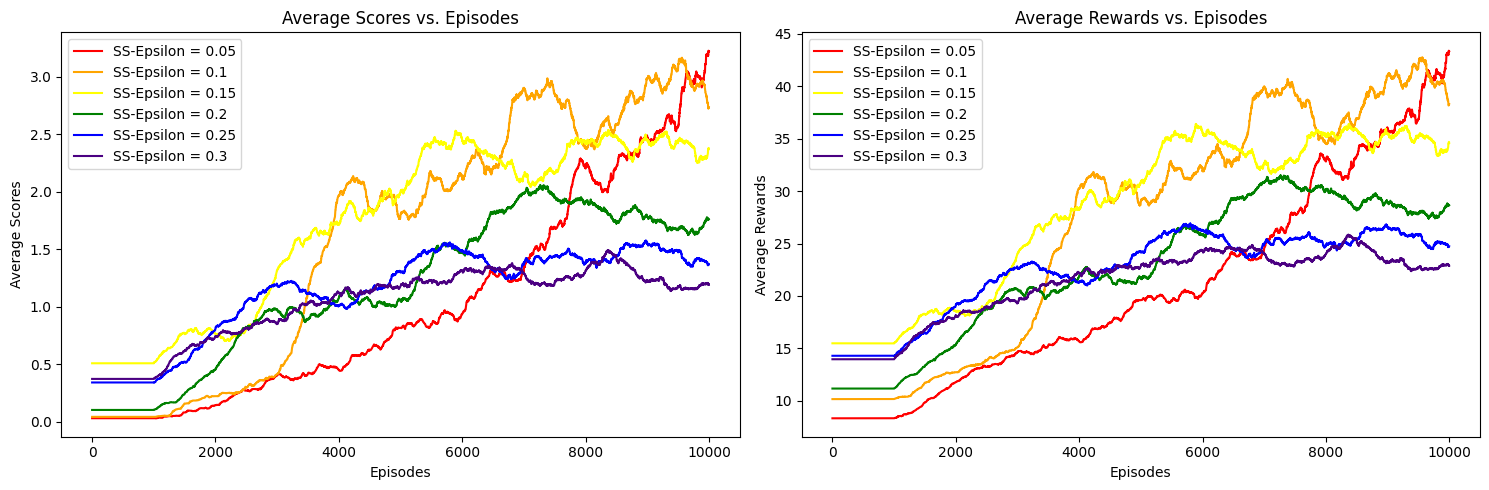

In [104]:
episodes = np.arange(0, 10000, 1)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5)) 

# Đồ thị đầu tiên cho Average Scores
ax1.plot(episodes, average_score_SS_eps005, label="SS-Epsilon = 0.05", color="red")
ax1.plot(episodes, average_score_SS_eps01, label="SS-Epsilon = 0.1", color="orange")
ax1.plot(episodes, average_score_SS_eps015, label="SS-Epsilon = 0.15", color="yellow")
ax1.plot(episodes, average_score_SS_eps020, label="SS-Epsilon = 0.2", color="green")
ax1.plot(episodes, average_score_SS_eps025, label="SS-Epsilon = 0.25", color="blue")
ax1.plot(episodes, average_score_SS_eps030, label="SS-Epsilon = 0.3", color="indigo")
ax1.set_xlabel("Episodes")
ax1.set_ylabel("Average Scores")
ax1.legend()
ax1.set_title("Average Scores vs. Episodes")

# Đồ thị thứ hai cho Average Rewards
ax2.plot(episodes, average_reward_SS_eps005, label="SS-Epsilon = 0.05", color="red")
ax2.plot(episodes, average_reward_SS_eps01, label="SS-Epsilon = 0.1", color="orange")
ax2.plot(episodes, average_reward_SS_eps015, label="SS-Epsilon = 0.15", color="yellow")
ax2.plot(episodes, average_reward_SS_eps020, label="SS-Epsilon = 0.2", color="green")
ax2.plot(episodes, average_reward_SS_eps025, label="SS-Epsilon = 0.25", color="blue")
ax2.plot(episodes, average_reward_SS_eps030, label="SS-Epsilon = 0.3", color="indigo")
ax2.set_xlabel("Episodes")
ax2.set_ylabel("Average Rewards")
ax2.legend()
ax2.set_title("Average Rewards vs. Episodes")

# Hiển thị cả hai đồ thị trong cùng một khung hình
plt.tight_layout()  # Điều chỉnh khoảng cách giữa các đồ thị
plt.show()


In [139]:
Q_agent = QLearningAgent(num_actions=2,epsilon=0.1,eps_decay=1,step_size=0.7,step_size_decay=1,discount=1,seed=0)
SS_agent = SARSAAgent(num_actions=2,epsilon=0.1,eps_decay=1,lr=0.7,discount=1,seed=0)

n_episodes = 10000
train_rewards_Q, train_scores_Q = Q_agent.train(env,n_episodes)
train_rewards_SS, train_scores_SS = SS_agent.train(env, n_episodes)

window = 1000
average_reward_Q_eps_decay_1 = [np.mean(train_rewards_Q[:window])]*window
average_reward_SS_eps_decay_1 = [np.mean(train_rewards_SS[:window])]*window
average_score_Q_eps_decay_1 = [np.mean(train_scores_Q[:window])]*window
average_score_SS_eps_decay_1 = [np.mean(train_scores_SS[:window])]*window
for ind in range(len(train_scores_Q) - window + 1):    
    average_score_Q_eps_decay_1.append(np.mean(train_scores_Q[ind:ind+window]))
for ind in range(len(train_scores_SS) - window + 1):
    average_score_SS_eps_decay_1.append(np.mean(train_scores_SS[ind:ind+window]))
for ind in range(len(train_rewards_Q) - window + 1):    
    average_reward_Q_eps_decay_1.append(np.mean(train_rewards_Q[ind:ind+window]))
for ind in range(len(train_rewards_SS) - window + 1):
    average_reward_SS_eps_decay_1.append(np.mean(train_rewards_SS[ind:ind+window]))

100%|██████████| 10000/10000 [00:07<00:00, 1362.15it/s]


In [140]:
Q_agent = QLearningAgent(num_actions=2,epsilon=0.1,eps_decay=0.99999,step_size=0.7,step_size_decay=1,discount=1,seed=0)
SS_agent = SARSAAgent(num_actions=2,epsilon=0.1,eps_decay=0.99999,lr=0.7,discount=1,seed=0)

n_episodes = 10000
train_rewards_Q, train_scores_Q = Q_agent.train(env,n_episodes)
train_rewards_SS, train_scores_SS = SS_agent.train(env, n_episodes)

window = 1000
average_reward_Q_eps_decay_099999 = [np.mean(train_rewards_Q[:window])]*window
average_reward_SS_eps_decay_099999 = [np.mean(train_rewards_SS[:window])]*window
average_score_Q_eps_decay_099999 = [np.mean(train_scores_Q[:window])]*window
average_score_SS_eps_decay_099999 = [np.mean(train_scores_SS[:window])]*window
for ind in range(len(train_scores_Q) - window + 1):    
    average_score_Q_eps_decay_099999.append(np.mean(train_scores_Q[ind:ind+window]))
for ind in range(len(train_scores_SS) - window + 1):
    average_score_SS_eps_decay_099999.append(np.mean(train_scores_SS[ind:ind+window]))
for ind in range(len(train_rewards_Q) - window + 1):    
    average_reward_Q_eps_decay_099999.append(np.mean(train_rewards_Q[ind:ind+window]))
for ind in range(len(train_rewards_SS) - window + 1):
    average_reward_SS_eps_decay_099999.append(np.mean(train_rewards_SS[ind:ind+window]))

  2%|▏         | 167/10000 [00:00<00:05, 1664.00it/s]

100%|██████████| 10000/10000 [00:08<00:00, 1114.36it/s]


In [141]:
Q_agent = QLearningAgent(num_actions=2,epsilon=0.1,eps_decay=0.9999,step_size=0.7,step_size_decay=1,discount=1,seed=0)
SS_agent = SARSAAgent(num_actions=2,epsilon=0.1,eps_decay=0.9999,lr=0.7,discount=1,seed=0)

n_episodes = 10000
train_rewards_Q, train_scores_Q = Q_agent.train(env,n_episodes)
train_rewards_SS, train_scores_SS = SS_agent.train(env, n_episodes)

window = 1000
average_reward_Q_eps_decay_09999 = [np.mean(train_rewards_Q[:window])]*window
average_reward_SS_eps_decay_09999 = [np.mean(train_rewards_SS[:window])]*window
average_score_Q_eps_decay_09999 = [np.mean(train_scores_Q[:window])]*window
average_score_SS_eps_decay_09999 = [np.mean(train_scores_SS[:window])]*window
for ind in range(len(train_scores_Q) - window + 1):    
    average_score_Q_eps_decay_09999.append(np.mean(train_scores_Q[ind:ind+window]))
for ind in range(len(train_scores_SS) - window + 1):
    average_score_SS_eps_decay_09999.append(np.mean(train_scores_SS[ind:ind+window]))
for ind in range(len(train_rewards_Q) - window + 1):    
    average_reward_Q_eps_decay_09999.append(np.mean(train_rewards_Q[ind:ind+window]))
for ind in range(len(train_rewards_SS) - window + 1):
    average_reward_SS_eps_decay_09999.append(np.mean(train_rewards_SS[ind:ind+window]))

100%|██████████| 10000/10000 [00:11<00:00, 864.39it/s]


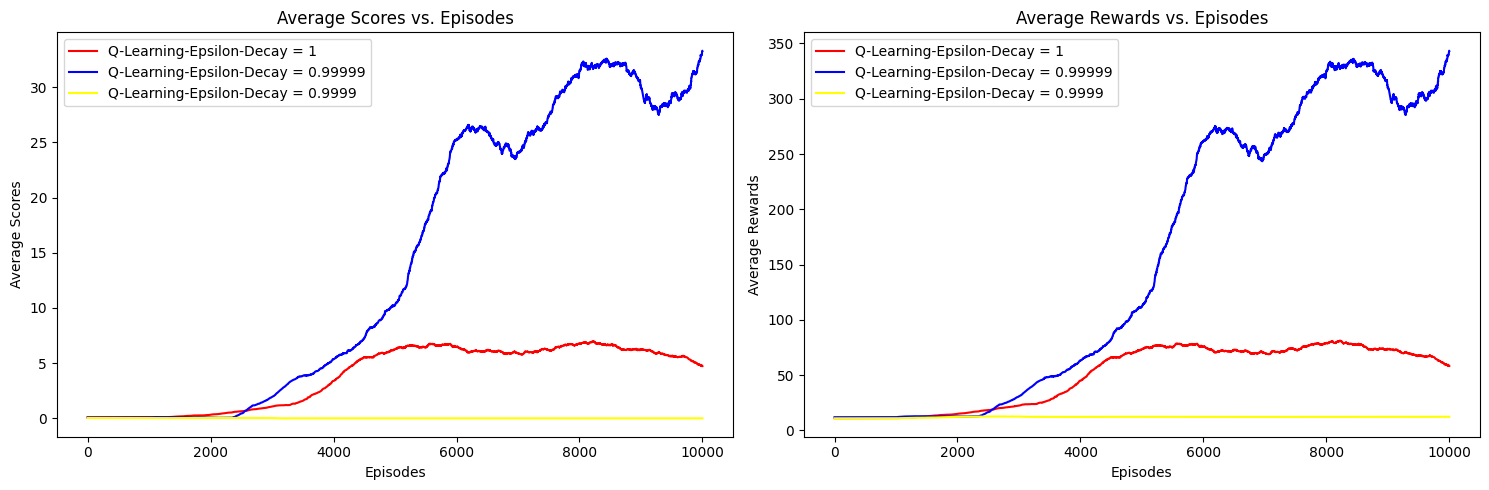

In [142]:
episodes = np.arange(0, 10000, 1)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5)) 

# Đồ thị đầu tiên cho Average Scores
ax1.plot(episodes, average_score_Q_eps_decay_1, label="Q-Learning-Epsilon-Decay = 1", color="red")
ax1.plot(episodes, average_score_Q_eps_decay_099999, label="Q-Learning-Epsilon-Decay = 0.99999", color="blue")
ax1.plot(episodes, average_score_Q_eps_decay_09999, label="Q-Learning-Epsilon-Decay = 0.9999", color="yellow")
ax1.set_xlabel("Episodes")
ax1.set_ylabel("Average Scores")
ax1.legend()
ax1.set_title("Average Scores vs. Episodes")

# Đồ thị thứ hai cho Average Rewards
ax2.plot(episodes, average_reward_Q_eps_decay_1, label="Q-Learning-Epsilon-Decay = 1", color="red")
ax2.plot(episodes, average_reward_Q_eps_decay_099999, label="Q-Learning-Epsilon-Decay = 0.99999", color="blue")
ax2.plot(episodes, average_reward_Q_eps_decay_09999, label="Q-Learning-Epsilon-Decay = 0.9999", color="yellow")
ax2.set_xlabel("Episodes")
ax2.set_ylabel("Average Rewards")
ax2.legend()
ax2.set_title("Average Rewards vs. Episodes")

# Hiển thị cả hai đồ thị trong cùng một khung hình
plt.tight_layout()  # Điều chỉnh khoảng cách giữa các đồ thị
plt.show()


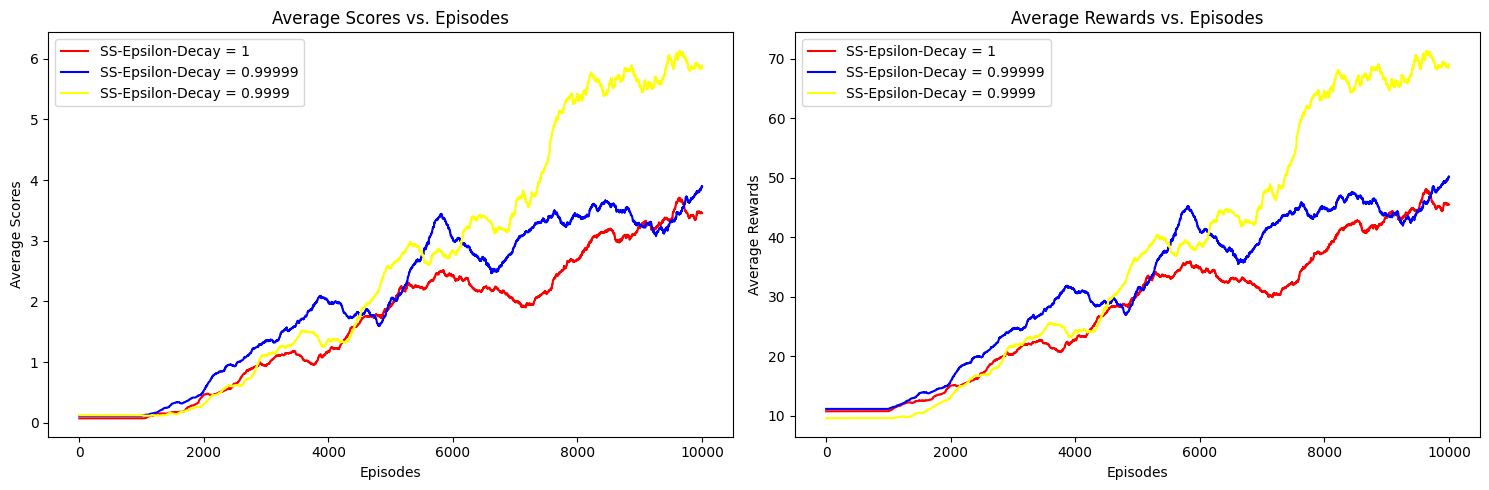

In [143]:
episodes = np.arange(0, 10000, 1)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5)) 

# Đồ thị đầu tiên cho Average Scores
ax1.plot(episodes, average_score_SS_eps_decay_1, label="SS-Epsilon-Decay = 1", color="red")
ax1.plot(episodes, average_score_SS_eps_decay_099999, label="SS-Epsilon-Decay = 0.99999", color="blue")
ax1.plot(episodes, average_score_SS_eps_decay_09999, label="SS-Epsilon-Decay = 0.9999", color="yellow")
ax1.set_xlabel("Episodes")
ax1.set_ylabel("Average Scores")
ax1.legend()
ax1.set_title("Average Scores vs. Episodes")

# Đồ thị thứ hai cho Average Rewards
ax2.plot(episodes, average_reward_SS_eps_decay_1, label="SS-Epsilon-Decay = 1", color="red")
ax2.plot(episodes, average_reward_SS_eps_decay_099999, label="SS-Epsilon-Decay = 0.99999", color="blue")
ax2.plot(episodes, average_reward_SS_eps_decay_09999, label="SS-Epsilon-Decay = 0.9999", color="yellow")
ax2.set_xlabel("Episodes")
ax2.set_ylabel("Average Rewards")
ax2.legend()
ax2.set_title("Average Rewards vs. Episodes")

# Hiển thị cả hai đồ thị trong cùng một khung hình
plt.tight_layout()  # Điều chỉnh khoảng cách giữa các đồ thị
plt.show()


In [79]:
Q_agent = QLearningAgent(num_actions=2,epsilon=0.1,eps_decay=1,step_size=0.1,step_size_decay=1,discount=1,seed=0)
SS_agent = SARSAAgent(num_actions=2,epsilon=0.1,eps_decay=1,lr=0.1,discount=1,seed=0)

n_episodes = 10000
train_rewards_Q, train_scores_Q = Q_agent.train(env,n_episodes)
train_rewards_SS, train_scores_SS = SS_agent.train(env, n_episodes)

window = 1000
average_reward_Q_ss_01 = [np.mean(train_rewards_Q[:window])]*window
average_reward_SS_ss_01 = [np.mean(train_rewards_SS[:window])]*window
average_score_Q_ss_01 = [np.mean(train_scores_Q[:window])]*window
average_score_SS_ss_01 = [np.mean(train_scores_SS[:window])]*window
for ind in range(len(train_scores_Q) - window + 1):    
    average_score_Q_ss_01.append(np.mean(train_scores_Q[ind:ind+window]))
for ind in range(len(train_scores_SS) - window + 1):
    average_score_SS_ss_01.append(np.mean(train_scores_SS[ind:ind+window]))
for ind in range(len(train_rewards_Q) - window + 1):    
    average_reward_Q_ss_01.append(np.mean(train_rewards_Q[ind:ind+window]))
for ind in range(len(train_rewards_SS) - window + 1):
    average_reward_SS_ss_01.append(np.mean(train_rewards_SS[ind:ind+window]))

100%|██████████| 10000/10000 [00:04<00:00, 2331.97it/s]


In [80]:
Q_agent = QLearningAgent(num_actions=2,epsilon=0.1,eps_decay=1,step_size=0.2,step_size_decay=1,discount=1,seed=0)
SS_agent = SARSAAgent(num_actions=2,epsilon=0.1,eps_decay=1,lr=0.2,discount=1,seed=0)

n_episodes = 10000
train_rewards_Q, train_scores_Q = Q_agent.train(env,n_episodes)
train_rewards_SS, train_scores_SS = SS_agent.train(env, n_episodes)

window = 1000
average_reward_Q_ss_02 = [np.mean(train_rewards_Q[:window])]*window
average_reward_SS_ss_02 = [np.mean(train_rewards_SS[:window])]*window
average_score_Q_ss_02 = [np.mean(train_scores_Q[:window])]*window
average_score_SS_ss_02 = [np.mean(train_scores_SS[:window])]*window
for ind in range(len(train_scores_Q) - window + 1):    
    average_score_Q_ss_02.append(np.mean(train_scores_Q[ind:ind+window]))
for ind in range(len(train_scores_SS) - window + 1):
    average_score_SS_ss_02.append(np.mean(train_scores_SS[ind:ind+window]))
for ind in range(len(train_rewards_Q) - window + 1):    
    average_reward_Q_ss_02.append(np.mean(train_rewards_Q[ind:ind+window]))
for ind in range(len(train_rewards_SS) - window + 1):
    average_reward_SS_ss_02.append(np.mean(train_rewards_SS[ind:ind+window]))

100%|██████████| 10000/10000 [00:08<00:00, 1194.09it/s]


In [81]:
Q_agent = QLearningAgent(num_actions=2,epsilon=0.1,eps_decay=1,step_size=0.3,step_size_decay=1,discount=1,seed=0)
SS_agent = SARSAAgent(num_actions=2,epsilon=0.1,eps_decay=1,lr=0.3,discount=1,seed=0)

n_episodes = 10000
train_rewards_Q, train_scores_Q = Q_agent.train(env,n_episodes)
train_rewards_SS, train_scores_SS = SS_agent.train(env, n_episodes)

window = 1000
average_reward_Q_ss_03 = [np.mean(train_rewards_Q[:window])]*window
average_reward_SS_ss_03 = [np.mean(train_rewards_SS[:window])]*window
average_score_Q_ss_03 = [np.mean(train_scores_Q[:window])]*window
average_score_SS_ss_03 = [np.mean(train_scores_SS[:window])]*window
for ind in range(len(train_scores_Q) - window + 1):    
    average_score_Q_ss_03.append(np.mean(train_scores_Q[ind:ind+window]))
for ind in range(len(train_scores_SS) - window + 1):
    average_score_SS_ss_03.append(np.mean(train_scores_SS[ind:ind+window]))
for ind in range(len(train_rewards_Q) - window + 1):    
    average_reward_Q_ss_03.append(np.mean(train_rewards_Q[ind:ind+window]))
for ind in range(len(train_rewards_SS) - window + 1):
    average_reward_SS_ss_03.append(np.mean(train_rewards_SS[ind:ind+window]))

100%|██████████| 10000/10000 [00:11<00:00, 904.22it/s]


In [82]:
Q_agent = QLearningAgent(num_actions=2,epsilon=0.1,eps_decay=1,step_size=0.4,step_size_decay=1,discount=1,seed=0)
SS_agent = SARSAAgent(num_actions=2,epsilon=0.1,eps_decay=1,lr=0.4,discount=1,seed=0)

n_episodes = 10000
train_rewards_Q, train_scores_Q = Q_agent.train(env,n_episodes)
train_rewards_SS, train_scores_SS = SS_agent.train(env, n_episodes)

window = 1000
average_reward_Q_ss_04 = [np.mean(train_rewards_Q[:window])]*window
average_reward_SS_ss_04 = [np.mean(train_rewards_SS[:window])]*window
average_score_Q_ss_04 = [np.mean(train_scores_Q[:window])]*window
average_score_SS_ss_04 = [np.mean(train_scores_SS[:window])]*window
for ind in range(len(train_scores_Q) - window + 1):    
    average_score_Q_ss_04.append(np.mean(train_scores_Q[ind:ind+window]))
for ind in range(len(train_scores_SS) - window + 1):
    average_score_SS_ss_04.append(np.mean(train_scores_SS[ind:ind+window]))
for ind in range(len(train_rewards_Q) - window + 1):    
    average_reward_Q_ss_04.append(np.mean(train_rewards_Q[ind:ind+window]))
for ind in range(len(train_rewards_SS) - window + 1):
    average_reward_SS_ss_04.append(np.mean(train_rewards_SS[ind:ind+window]))

100%|██████████| 10000/10000 [00:12<00:00, 806.00it/s]


In [83]:
Q_agent = QLearningAgent(num_actions=2,epsilon=0.1,eps_decay=1,step_size=0.5,step_size_decay=1,discount=1,seed=0)
SS_agent = SARSAAgent(num_actions=2,epsilon=0.1,eps_decay=1,lr=0.5,discount=1,seed=0)

n_episodes = 10000
train_rewards_Q, train_scores_Q = Q_agent.train(env,n_episodes)
train_rewards_SS, train_scores_SS = SS_agent.train(env, n_episodes)

window = 1000
average_reward_Q_ss_05 = [np.mean(train_rewards_Q[:window])]*window
average_reward_SS_ss_05 = [np.mean(train_rewards_SS[:window])]*window
average_score_Q_ss_05 = [np.mean(train_scores_Q[:window])]*window
average_score_SS_ss_05 = [np.mean(train_scores_SS[:window])]*window
for ind in range(len(train_scores_Q) - window + 1):    
    average_score_Q_ss_05.append(np.mean(train_scores_Q[ind:ind+window]))
for ind in range(len(train_scores_SS) - window + 1):
    average_score_SS_ss_05.append(np.mean(train_scores_SS[ind:ind+window]))
for ind in range(len(train_rewards_Q) - window + 1):    
    average_reward_Q_ss_05.append(np.mean(train_rewards_Q[ind:ind+window]))
for ind in range(len(train_rewards_SS) - window + 1):
    average_reward_SS_ss_05.append(np.mean(train_rewards_SS[ind:ind+window]))

100%|██████████| 10000/10000 [00:12<00:00, 789.74it/s]


In [84]:
Q_agent = QLearningAgent(num_actions=2,epsilon=0.1,eps_decay=1,step_size=0.6,step_size_decay=1,discount=1,seed=0)
SS_agent = SARSAAgent(num_actions=2,epsilon=0.1,eps_decay=1,lr=0.6,discount=1,seed=0)

n_episodes = 10000
train_rewards_Q, train_scores_Q = Q_agent.train(env,n_episodes)
train_rewards_SS, train_scores_SS = SS_agent.train(env, n_episodes)

window = 1000
average_reward_Q_ss_06 = [np.mean(train_rewards_Q[:window])]*window
average_reward_SS_ss_06 = [np.mean(train_rewards_SS[:window])]*window
average_score_Q_ss_06 = [np.mean(train_scores_Q[:window])]*window
average_score_SS_ss_06 = [np.mean(train_scores_SS[:window])]*window
for ind in range(len(train_scores_Q) - window + 1):    
    average_score_Q_ss_06.append(np.mean(train_scores_Q[ind:ind+window]))
for ind in range(len(train_scores_SS) - window + 1):
    average_score_SS_ss_06.append(np.mean(train_scores_SS[ind:ind+window]))
for ind in range(len(train_rewards_Q) - window + 1):    
    average_reward_Q_ss_06.append(np.mean(train_rewards_Q[ind:ind+window]))
for ind in range(len(train_rewards_SS) - window + 1):
    average_reward_SS_ss_06.append(np.mean(train_rewards_SS[ind:ind+window]))

100%|██████████| 10000/10000 [00:11<00:00, 857.51it/s]


In [85]:
Q_agent = QLearningAgent(num_actions=2,epsilon=0.1,eps_decay=1,step_size=0.7,step_size_decay=1,discount=1,seed=0)
SS_agent = SARSAAgent(num_actions=2,epsilon=0.1,eps_decay=1,lr=0.7,discount=1,seed=0)

n_episodes = 10000
train_rewards_Q, train_scores_Q = Q_agent.train(env,n_episodes)
train_rewards_SS, train_scores_SS = SS_agent.train(env, n_episodes)

window = 1000
average_reward_Q_ss_07 = [np.mean(train_rewards_Q[:window])]*window
average_reward_SS_ss_07 = [np.mean(train_rewards_SS[:window])]*window
average_score_Q_ss_07 = [np.mean(train_scores_Q[:window])]*window
average_score_SS_ss_07 = [np.mean(train_scores_SS[:window])]*window
for ind in range(len(train_scores_Q) - window + 1):    
    average_score_Q_ss_07.append(np.mean(train_scores_Q[ind:ind+window]))
for ind in range(len(train_scores_SS) - window + 1):
    average_score_SS_ss_07.append(np.mean(train_scores_SS[ind:ind+window]))
for ind in range(len(train_rewards_Q) - window + 1):    
    average_reward_Q_ss_07.append(np.mean(train_rewards_Q[ind:ind+window]))
for ind in range(len(train_rewards_SS) - window + 1):
    average_reward_SS_ss_07.append(np.mean(train_rewards_SS[ind:ind+window]))

100%|██████████| 10000/10000 [00:09<00:00, 1101.24it/s]


In [86]:
Q_agent = QLearningAgent(num_actions=2,epsilon=0.1,eps_decay=1,step_size=0.8,step_size_decay=1,discount=1,seed=0)
SS_agent = SARSAAgent(num_actions=2,epsilon=0.1,eps_decay=1,lr=0.8,discount=1,seed=0)

n_episodes = 10000
train_rewards_Q, train_scores_Q = Q_agent.train(env,n_episodes)
train_rewards_SS, train_scores_SS = SS_agent.train(env, n_episodes)

window = 1000
average_reward_Q_ss_08 = [np.mean(train_rewards_Q[:window])]*window
average_reward_SS_ss_08 = [np.mean(train_rewards_SS[:window])]*window
average_score_Q_ss_08 = [np.mean(train_scores_Q[:window])]*window
average_score_SS_ss_08 = [np.mean(train_scores_SS[:window])]*window
for ind in range(len(train_scores_Q) - window + 1):    
    average_score_Q_ss_08.append(np.mean(train_scores_Q[ind:ind+window]))
for ind in range(len(train_scores_SS) - window + 1):
    average_score_SS_ss_08.append(np.mean(train_scores_SS[ind:ind+window]))
for ind in range(len(train_rewards_Q) - window + 1):    
    average_reward_Q_ss_08.append(np.mean(train_rewards_Q[ind:ind+window]))
for ind in range(len(train_rewards_SS) - window + 1):
    average_reward_SS_ss_08.append(np.mean(train_rewards_SS[ind:ind+window]))

100%|██████████| 10000/10000 [00:07<00:00, 1298.87it/s]


In [87]:
Q_agent = QLearningAgent(num_actions=2,epsilon=0.1,eps_decay=1,step_size=0.9,step_size_decay=1,discount=1,seed=0)
SS_agent = SARSAAgent(num_actions=2,epsilon=0.1,eps_decay=1,lr=0.9,discount=1,seed=0)

n_episodes = 10000
train_rewards_Q, train_scores_Q = Q_agent.train(env,n_episodes)
train_rewards_SS, train_scores_SS = SS_agent.train(env, n_episodes)

window = 1000
average_reward_Q_ss_09 = [np.mean(train_rewards_Q[:window])]*window
average_reward_SS_ss_09 = [np.mean(train_rewards_SS[:window])]*window
average_score_Q_ss_09 = [np.mean(train_scores_Q[:window])]*window
average_score_SS_ss_09 = [np.mean(train_scores_SS[:window])]*window
for ind in range(len(train_scores_Q) - window + 1):    
    average_score_Q_ss_09.append(np.mean(train_scores_Q[ind:ind+window]))
for ind in range(len(train_scores_SS) - window + 1):
    average_score_SS_ss_09.append(np.mean(train_scores_SS[ind:ind+window]))
for ind in range(len(train_rewards_Q) - window + 1):    
    average_reward_Q_ss_09.append(np.mean(train_rewards_Q[ind:ind+window]))
for ind in range(len(train_rewards_SS) - window + 1):
    average_reward_SS_ss_09.append(np.mean(train_rewards_SS[ind:ind+window]))

100%|██████████| 10000/10000 [00:04<00:00, 2407.85it/s]


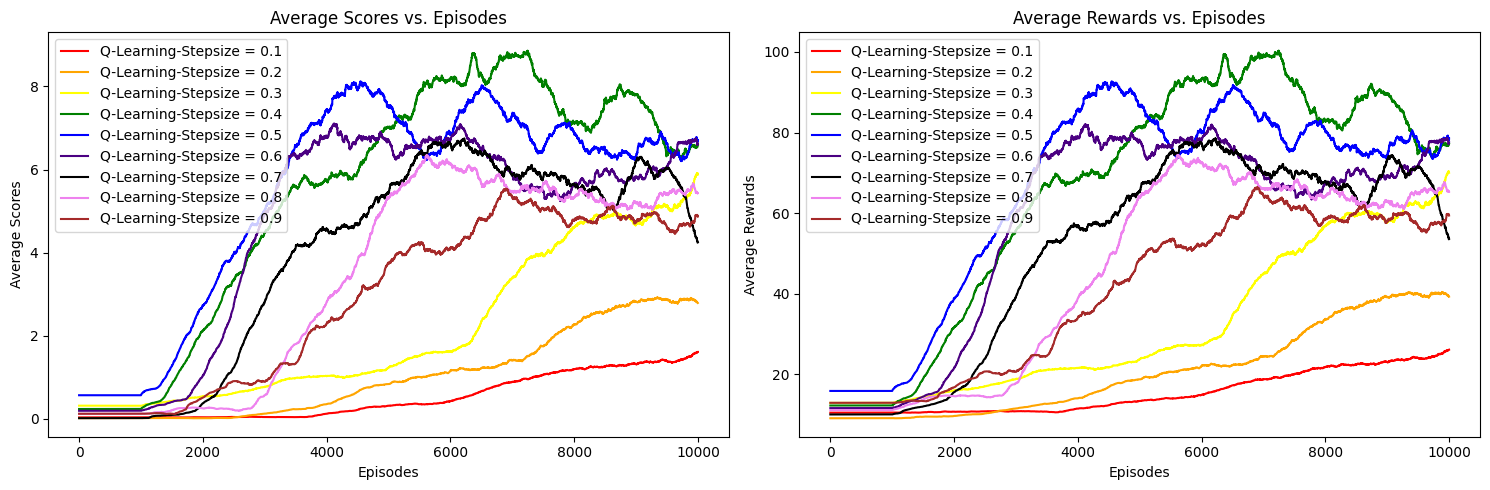

In [106]:
episodes = np.arange(0, 10000, 1)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5)) 

# Đồ thị đầu tiên cho Average Scores
ax1.plot(episodes, average_score_Q_ss_01, label="Q-Learning-Stepsize = 0.1", color="red")
ax1.plot(episodes, average_score_Q_ss_02, label="Q-Learning-Stepsize = 0.2", color="orange")
ax1.plot(episodes, average_score_Q_ss_03, label="Q-Learning-Stepsize = 0.3", color="yellow")
ax1.plot(episodes, average_score_Q_ss_04, label="Q-Learning-Stepsize = 0.4", color="green")
ax1.plot(episodes, average_score_Q_ss_05, label="Q-Learning-Stepsize = 0.5", color="blue")
ax1.plot(episodes, average_score_Q_ss_06, label="Q-Learning-Stepsize = 0.6", color="indigo")
ax1.plot(episodes, average_score_Q_ss_07, label="Q-Learning-Stepsize = 0.7", color="black")
ax1.plot(episodes, average_score_Q_ss_08, label="Q-Learning-Stepsize = 0.8", color="violet")
ax1.plot(episodes, average_score_Q_ss_09, label="Q-Learning-Stepsize = 0.9", color="brown")
ax1.set_xlabel("Episodes")
ax1.set_ylabel("Average Scores")
ax1.legend()
ax1.set_title("Average Scores vs. Episodes")

# Đồ thị thứ hai cho Average Rewards
ax2.plot(episodes, average_reward_Q_ss_01, label="Q-Learning-Stepsize = 0.1", color="red")
ax2.plot(episodes, average_reward_Q_ss_02, label="Q-Learning-Stepsize = 0.2", color="orange")
ax2.plot(episodes, average_reward_Q_ss_03, label="Q-Learning-Stepsize = 0.3", color="yellow")
ax2.plot(episodes, average_reward_Q_ss_04, label="Q-Learning-Stepsize = 0.4", color="green")
ax2.plot(episodes, average_reward_Q_ss_05, label="Q-Learning-Stepsize = 0.5", color="blue")
ax2.plot(episodes, average_reward_Q_ss_06, label="Q-Learning-Stepsize = 0.6", color="indigo")
ax2.plot(episodes, average_reward_Q_ss_07, label="Q-Learning-Stepsize = 0.7", color="black")
ax2.plot(episodes, average_reward_Q_ss_08, label="Q-Learning-Stepsize = 0.8", color="violet")
ax2.plot(episodes, average_reward_Q_ss_09, label="Q-Learning-Stepsize = 0.9", color="brown")
ax2.set_xlabel("Episodes")
ax2.set_ylabel("Average Rewards")
ax2.legend()
ax2.set_title("Average Rewards vs. Episodes")

# Hiển thị cả hai đồ thị trong cùng một khung hình
plt.tight_layout()  # Điều chỉnh khoảng cách giữa các đồ thị
plt.show()


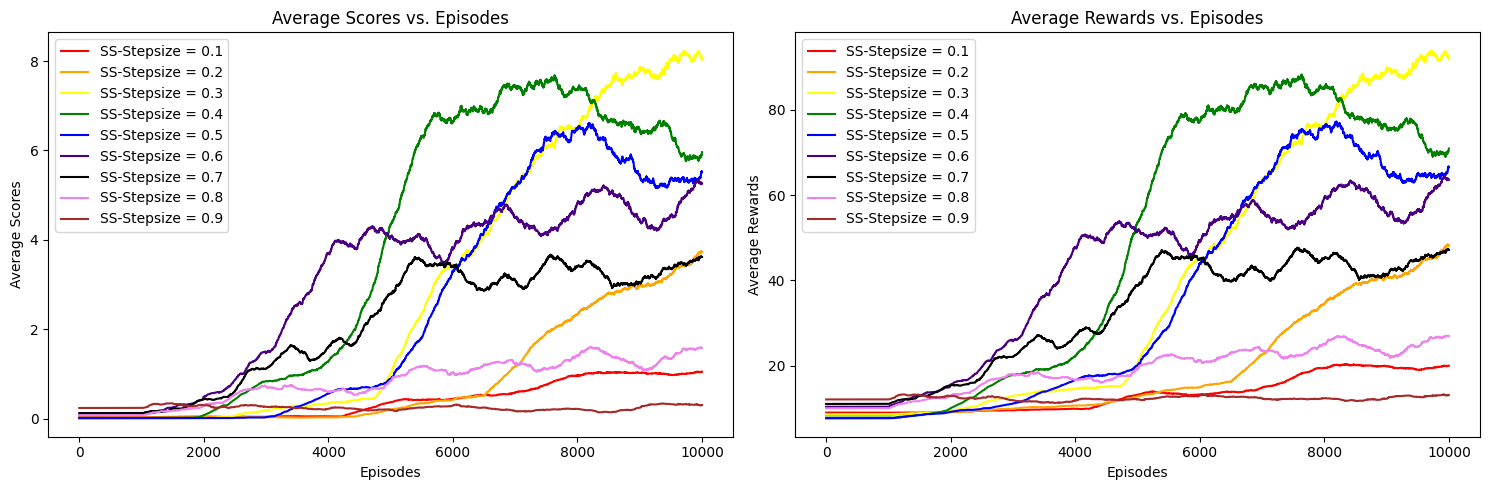

In [107]:
episodes = np.arange(0, 10000, 1)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5)) 

# Đồ thị đầu tiên cho Average Scores
ax1.plot(episodes, average_score_SS_ss_01, label="SS-Stepsize = 0.1", color="red")
ax1.plot(episodes, average_score_SS_ss_02, label="SS-Stepsize = 0.2", color="orange")
ax1.plot(episodes, average_score_SS_ss_03, label="SS-Stepsize = 0.3", color="yellow")
ax1.plot(episodes, average_score_SS_ss_04, label="SS-Stepsize = 0.4", color="green")
ax1.plot(episodes, average_score_SS_ss_05, label="SS-Stepsize = 0.5", color="blue")
ax1.plot(episodes, average_score_SS_ss_06, label="SS-Stepsize = 0.6", color="indigo")
ax1.plot(episodes, average_score_SS_ss_07, label="SS-Stepsize = 0.7", color="black")
ax1.plot(episodes, average_score_SS_ss_08, label="SS-Stepsize = 0.8", color="violet")
ax1.plot(episodes, average_score_SS_ss_09, label="SS-Stepsize = 0.9", color="brown")
ax1.set_xlabel("Episodes")
ax1.set_ylabel("Average Scores")
ax1.legend()
ax1.set_title("Average Scores vs. Episodes")

# Đồ thị thứ hai cho Average Rewards
ax2.plot(episodes, average_reward_SS_ss_01, label="SS-Stepsize = 0.1", color="red")
ax2.plot(episodes, average_reward_SS_ss_02, label="SS-Stepsize = 0.2", color="orange")
ax2.plot(episodes, average_reward_SS_ss_03, label="SS-Stepsize = 0.3", color="yellow")
ax2.plot(episodes, average_reward_SS_ss_04, label="SS-Stepsize = 0.4", color="green")
ax2.plot(episodes, average_reward_SS_ss_05, label="SS-Stepsize = 0.5", color="blue")
ax2.plot(episodes, average_reward_SS_ss_06, label="SS-Stepsize = 0.6", color="indigo")
ax2.plot(episodes, average_reward_SS_ss_07, label="SS-Stepsize = 0.7", color="black")
ax2.plot(episodes, average_reward_SS_ss_08, label="SS-Stepsize = 0.8", color="violet")
ax2.plot(episodes, average_reward_SS_ss_09, label="SS-Stepsize = 0.9", color="brown")
ax2.set_xlabel("Episodes")
ax2.set_ylabel("Average Rewards")
ax2.legend()
ax2.set_title("Average Rewards vs. Episodes")

# Hiển thị cả hai đồ thị trong cùng một khung hình
plt.tight_layout()  # Điều chỉnh khoảng cách giữa các đồ thị
plt.show()


In [125]:
Q_agent = QLearningAgent(num_actions=2,epsilon=0.05,eps_decay=1,step_size=0.7,step_size_decay=1,discount=1,seed=0)
SS_agent = SARSAAgent(num_actions=2,epsilon=0.05,eps_decay=1,lr=0.7,discount=1,seed=0)

n_episodes = 10000
train_rewards_Q, train_scores_Q = Q_agent.train(env,n_episodes)
train_rewards_SS, train_scores_SS = SS_agent.train(env, n_episodes)

window = 1000
average_reward_Q_eps_decay_1 = [np.mean(train_rewards_Q[:window])]*window
average_reward_SS_eps_decay_1 = [np.mean(train_rewards_SS[:window])]*window
average_score_Q_eps_decay_1 = [np.mean(train_scores_Q[:window])]*window
average_score_SS_eps_decay_1 = [np.mean(train_scores_SS[:window])]*window
for ind in range(len(train_scores_Q) - window + 1):    
    average_score_Q_eps_decay_1.append(np.mean(train_scores_Q[ind:ind+window]))
for ind in range(len(train_scores_SS) - window + 1):
    average_score_SS_eps_decay_1.append(np.mean(train_scores_SS[ind:ind+window]))
for ind in range(len(train_rewards_Q) - window + 1):    
    average_reward_Q_eps_decay_1.append(np.mean(train_rewards_Q[ind:ind+window]))
for ind in range(len(train_rewards_SS) - window + 1):
    average_reward_SS_eps_decay_1.append(np.mean(train_rewards_SS[ind:ind+window]))

100%|██████████| 10000/10000 [00:09<00:00, 1094.12it/s]


In [ ]:
Q_agent = QLearningAgent(num_actions=2,epsilon=0.05,eps_decay=0.99999,step_size=0.7,step_size_decay=1,discount=1,seed=0)
SS_agent = SARSAAgent(num_actions=2,epsilon=0.05,eps_decay=0.99999,lr=0.7,discount=1,seed=0)

n_episodes = 10000
train_rewards_Q, train_scores_Q = Q_agent.train(env,n_episodes)
train_rewards_SS, train_scores_SS = SS_agent.train(env, n_episodes)

window = 1000
average_reward_Q_eps_decay_099999 = [np.mean(train_rewards_Q[:window])]*window
average_reward_SS_eps_decay_099999 = [np.mean(train_rewards_SS[:window])]*window
average_score_Q_eps_decay_099999 = [np.mean(train_scores_Q[:window])]*window
average_score_SS_eps_decay_099999 = [np.mean(train_scores_SS[:window])]*window
for ind in range(len(train_scores_Q) - window + 1):    
    average_score_Q_eps_decay_099999.append(np.mean(train_scores_Q[ind:ind+window]))
for ind in range(len(train_scores_SS) - window + 1):
    average_score_SS_eps_decay_099999.append(np.mean(train_scores_SS[ind:ind+window]))
for ind in range(len(train_rewards_Q) - window + 1):    
    average_reward_Q_eps_decay_099999.append(np.mean(train_rewards_Q[ind:ind+window]))
for ind in range(len(train_rewards_SS) - window + 1):
    average_reward_SS_eps_decay_099999.append(np.mean(train_rewards_SS[ind:ind+window]))

In [ ]:
Q_agent = QLearningAgent(num_actions=2,epsilon=0.05,eps_decay=0.9999,step_size=0.7,step_size_decay=1,discount=1,seed=0)
SS_agent = SARSAAgent(num_actions=2,epsilon=0.05,eps_decay=0.9999,lr=0.7,discount=1,seed=0)

n_episodes = 10000
train_rewards_Q, train_scores_Q = Q_agent.train(env,n_episodes)
train_rewards_SS, train_scores_SS = SS_agent.train(env, n_episodes)

window = 1000
average_reward_Q_eps_decay_09999 = [np.mean(train_rewards_Q[:window])]*window
average_reward_SS_eps_decay_09999 = [np.mean(train_rewards_SS[:window])]*window
average_score_Q_eps_decay_09999 = [np.mean(train_scores_Q[:window])]*window
average_score_SS_eps_decay_09999 = [np.mean(train_scores_SS[:window])]*window
for ind in range(len(train_scores_Q) - window + 1):    
    average_score_Q_eps_decay_09999.append(np.mean(train_scores_Q[ind:ind+window]))
for ind in range(len(train_scores_SS) - window + 1):
    average_score_SS_eps_decay_09999.append(np.mean(train_scores_SS[ind:ind+window]))
for ind in range(len(train_rewards_Q) - window + 1):    
    average_reward_Q_eps_decay_09999.append(np.mean(train_rewards_Q[ind:ind+window]))
for ind in range(len(train_rewards_SS) - window + 1):
    average_reward_SS_eps_decay_09999.append(np.mean(train_rewards_SS[ind:ind+window]))

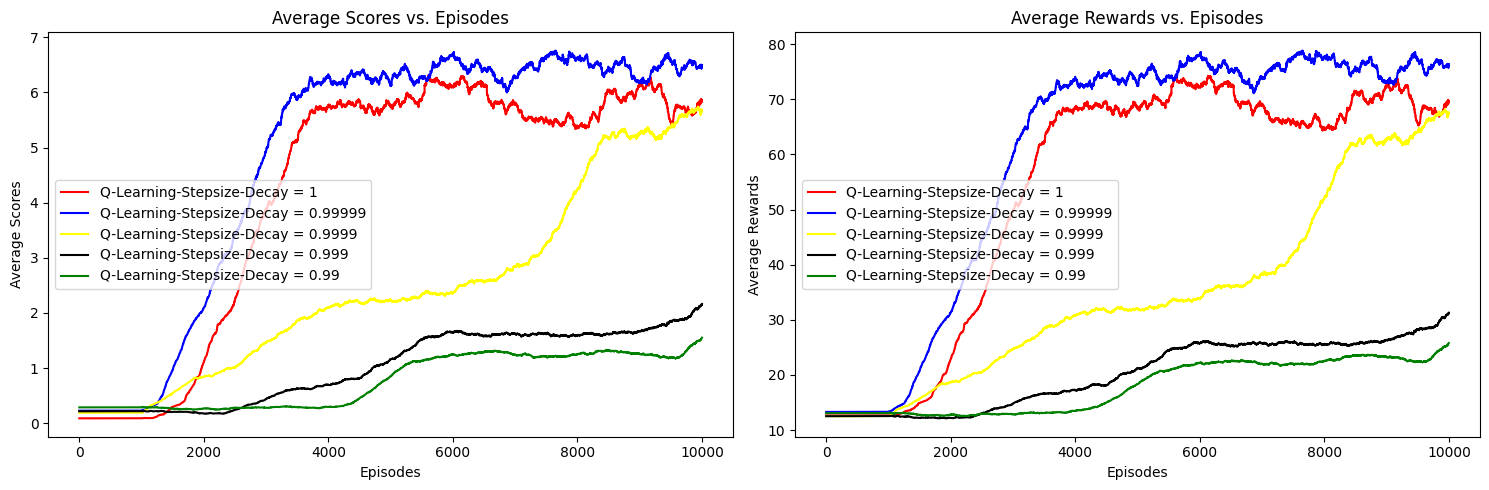

In [108]:
episodes = np.arange(0, 10000, 1)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5)) 

# Đồ thị đầu tiên cho Average Scores
ax1.plot(episodes, average_score_Q_ssd_1, label="Q-Learning-Stepsize-Decay = 1", color="red")
ax1.plot(episodes, average_score_Q_ssd_099999, label="Q-Learning-Stepsize-Decay = 0.99999", color="blue")
ax1.plot(episodes, average_score_Q_ssd_09999, label="Q-Learning-Stepsize-Decay = 0.9999", color="yellow")
ax1.plot(episodes, average_score_Q_ssd_0999, label="Q-Learning-Stepsize-Decay = 0.999", color="black")
ax1.plot(episodes, average_score_Q_ssd_099, label="Q-Learning-Stepsize-Decay = 0.99", color="green")
ax1.set_xlabel("Episodes")
ax1.set_ylabel("Average Scores")
ax1.legend()
ax1.set_title("Average Scores vs. Episodes")

# Đồ thị thứ hai cho Average Rewards
ax2.plot(episodes, average_reward_Q_ssd_1, label="Q-Learning-Stepsize-Decay = 1", color="red")
ax2.plot(episodes, average_reward_Q_ssd_099999, label="Q-Learning-Stepsize-Decay = 0.99999", color="blue")
ax2.plot(episodes, average_reward_Q_ssd_09999, label="Q-Learning-Stepsize-Decay = 0.9999", color="yellow")
ax2.plot(episodes, average_reward_Q_ssd_0999, label="Q-Learning-Stepsize-Decay = 0.999", color="black")
ax2.plot(episodes, average_reward_Q_ssd_099, label="Q-Learning-Stepsize-Decay = 0.99", color="green")
ax2.set_xlabel("Episodes")
ax2.set_ylabel("Average Rewards")
ax2.legend()
ax2.set_title("Average Rewards vs. Episodes")

# Hiển thị cả hai đồ thị trong cùng một khung hình
plt.tight_layout()  # Điều chỉnh khoảng cách giữa các đồ thị
plt.show()


In [ ]:
episodes = np.arange(0, 10000, 1)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5)) 

# Đồ thị đầu tiên cho Average Scores
ax1.plot(episodes, average_score_Q_ssd_1, label="Q-Learning-Stepsize-Decay = 1", color="red")
ax1.plot(episodes, average_score_Q_ssd_099999, label="Q-Learning-Stepsize-Decay = 0.99999", color="blue")
ax1.plot(episodes, average_score_Q_ssd_09999, label="Q-Learning-Stepsize-Decay = 0.9999", color="yellow")
ax1.plot(episodes, average_score_Q_ssd_0999, label="Q-Learning-Stepsize-Decay = 0.999", color="black")
ax1.plot(episodes, average_score_Q_ssd_099, label="Q-Learning-Stepsize-Decay = 0.99", color="green")
ax1.set_xlabel("Episodes")
ax1.set_ylabel("Average Scores")
ax1.legend()
ax1.set_title("Average Scores vs. Episodes")

# Đồ thị thứ hai cho Average Rewards
ax2.plot(episodes, average_reward_Q_ssd_1, label="Q-Learning-Stepsize-Decay = 1", color="red")
ax2.plot(episodes, average_reward_Q_ssd_099999, label="Q-Learning-Stepsize-Decay = 0.99999", color="blue")
ax2.plot(episodes, average_reward_Q_ssd_09999, label="Q-Learning-Stepsize-Decay = 0.9999", color="yellow")
ax2.plot(episodes, average_reward_Q_ssd_0999, label="Q-Learning-Stepsize-Decay = 0.999", color="black")
ax2.plot(episodes, average_reward_Q_ssd_099, label="Q-Learning-Stepsize-Decay = 0.99", color="green")
ax2.set_xlabel("Episodes")
ax2.set_ylabel("Average Rewards")
ax2.legend()
ax2.set_title("Average Rewards vs. Episodes")

# Hiển thị cả hai đồ thị trong cùng một khung hình
plt.tight_layout()  # Điều chỉnh khoảng cách giữa các đồ thị
plt.show()


In [109]:
mc_agent = MonteCarlo(gamma=0.5, epsilon=0.1)
n_episodes = 10000
train_rewards_mc, train_scores_mc = mc_agent.train(env,n_episodes)

window = 1000
average_reward_mc_eps_01 = [np.mean(train_rewards_mc[:window])]*window
average_score_mc_eps_01 = [np.mean(train_scores_mc[:window])]*window
for ind in range(len(train_scores_mc) - window + 1):    
    average_score_mc_eps_01.append(np.mean(train_scores_mc[ind:ind+window]))
for ind in range(len(train_rewards_mc) - window + 1):    
    average_reward_mc_eps_01.append(np.mean(train_rewards_mc[ind:ind+window]))

100%|██████████| 10000/10000 [00:16<00:00, 617.45it/s]


In [110]:
mc_agent = MonteCarlo(gamma=0.5, epsilon=0.2)
n_episodes = 10000
train_rewards_mc, train_scores_mc = mc_agent.train(env,n_episodes)

window = 1000
average_reward_mc_eps_02 = [np.mean(train_rewards_mc[:window])]*window
average_score_mc_eps_02 = [np.mean(train_scores_mc[:window])]*window
for ind in range(len(train_scores_mc) - window + 1):    
    average_score_mc_eps_02.append(np.mean(train_scores_mc[ind:ind+window]))
for ind in range(len(train_rewards_mc) - window + 1):    
    average_reward_mc_eps_02.append(np.mean(train_rewards_mc[ind:ind+window]))

100%|██████████| 10000/10000 [00:10<00:00, 917.03it/s]


In [111]:
mc_agent = MonteCarlo(gamma=0.5, epsilon=0.3)
n_episodes = 10000
train_rewards_mc, train_scores_mc = mc_agent.train(env,n_episodes)

window = 1000
average_reward_mc_eps_03 = [np.mean(train_rewards_mc[:window])]*window
average_score_mc_eps_03 = [np.mean(train_scores_mc[:window])]*window
for ind in range(len(train_scores_mc) - window + 1):    
    average_score_mc_eps_03.append(np.mean(train_scores_mc[ind:ind+window]))
for ind in range(len(train_rewards_mc) - window + 1):    
    average_reward_mc_eps_03.append(np.mean(train_rewards_mc[ind:ind+window]))

100%|██████████| 10000/10000 [00:07<00:00, 1340.35it/s]


In [112]:
mc_agent = MonteCarlo(gamma=0.5, epsilon=0.4)
n_episodes = 10000
train_rewards_mc, train_scores_mc = mc_agent.train(env,n_episodes)

window = 1000
average_reward_mc_eps_04 = [np.mean(train_rewards_mc[:window])]*window
average_score_mc_eps_04 = [np.mean(train_scores_mc[:window])]*window
for ind in range(len(train_scores_mc) - window + 1):    
    average_score_mc_eps_04.append(np.mean(train_scores_mc[ind:ind+window]))
for ind in range(len(train_rewards_mc) - window + 1):    
    average_reward_mc_eps_04.append(np.mean(train_rewards_mc[ind:ind+window]))

100%|██████████| 10000/10000 [00:06<00:00, 1659.60it/s]


In [113]:
mc_agent = MonteCarlo(gamma=0.5, epsilon=0.5)
n_episodes = 10000
train_rewards_mc, train_scores_mc = mc_agent.train(env,n_episodes)

window = 1000
average_reward_mc_eps_05 = [np.mean(train_rewards_mc[:window])]*window
average_score_mc_eps_05 = [np.mean(train_scores_mc[:window])]*window
for ind in range(len(train_scores_mc) - window + 1):    
    average_score_mc_eps_05.append(np.mean(train_scores_mc[ind:ind+window]))
for ind in range(len(train_rewards_mc) - window + 1):    
    average_reward_mc_eps_05.append(np.mean(train_rewards_mc[ind:ind+window]))

100%|██████████| 10000/10000 [00:04<00:00, 2110.04it/s]


In [114]:
mc_agent = MonteCarlo(gamma=0.5, epsilon=0.6)
n_episodes = 10000
train_rewards_mc, train_scores_mc = mc_agent.train(env,n_episodes)

window = 1000
average_reward_mc_eps_06 = [np.mean(train_rewards_mc[:window])]*window
average_score_mc_eps_06 = [np.mean(train_scores_mc[:window])]*window
for ind in range(len(train_scores_mc) - window + 1):    
    average_score_mc_eps_06.append(np.mean(train_scores_mc[ind:ind+window]))
for ind in range(len(train_rewards_mc) - window + 1):    
    average_reward_mc_eps_06.append(np.mean(train_rewards_mc[ind:ind+window]))

100%|██████████| 10000/10000 [00:03<00:00, 2576.70it/s]


In [115]:
mc_agent = MonteCarlo(gamma=0.5, epsilon=0.7)
n_episodes = 10000
train_rewards_mc, train_scores_mc = mc_agent.train(env,n_episodes)

window = 1000
average_reward_mc_eps_07 = [np.mean(train_rewards_mc[:window])]*window
average_score_mc_eps_07 = [np.mean(train_scores_mc[:window])]*window
for ind in range(len(train_scores_mc) - window + 1):    
    average_score_mc_eps_07.append(np.mean(train_scores_mc[ind:ind+window]))
for ind in range(len(train_rewards_mc) - window + 1):    
    average_reward_mc_eps_07.append(np.mean(train_rewards_mc[ind:ind+window]))

100%|██████████| 10000/10000 [00:03<00:00, 2786.31it/s]


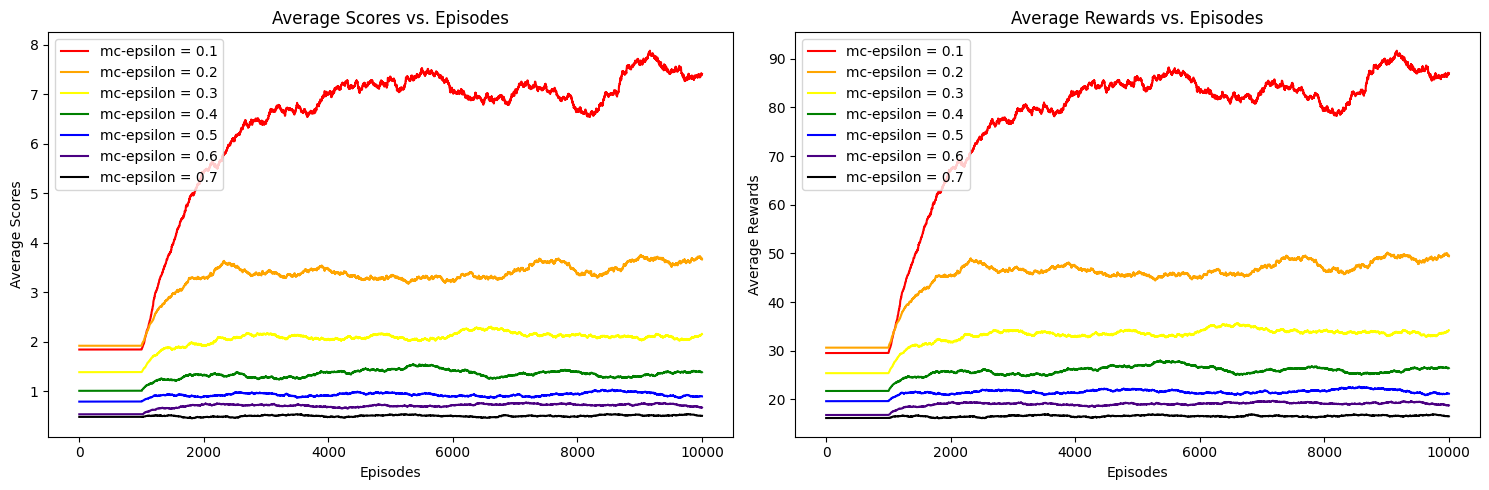

In [117]:
episodes = np.arange(0, 10001, 1)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5)) 

# Đồ thị đầu tiên cho Average Scores
ax1.plot(episodes, average_score_mc_eps_01, label="mc-epsilon = 0.1", color="red")
ax1.plot(episodes, average_score_mc_eps_02, label="mc-epsilon = 0.2", color="orange")
ax1.plot(episodes, average_score_mc_eps_03, label="mc-epsilon = 0.3", color="yellow")
ax1.plot(episodes, average_score_mc_eps_04, label="mc-epsilon = 0.4", color="green")
ax1.plot(episodes, average_score_mc_eps_05, label="mc-epsilon = 0.5", color="blue")
ax1.plot(episodes, average_score_mc_eps_06, label="mc-epsilon = 0.6", color="indigo")
ax1.plot(episodes, average_score_mc_eps_07, label="mc-epsilon = 0.7", color="black")
ax1.set_xlabel("Episodes")
ax1.set_ylabel("Average Scores")
ax1.legend()
ax1.set_title("Average Scores vs. Episodes")

# Đồ thị thứ hai cho Average Rewards
ax2.plot(episodes, average_reward_mc_eps_01, label="mc-epsilon = 0.1", color="red")
ax2.plot(episodes, average_reward_mc_eps_02, label="mc-epsilon = 0.2", color="orange")
ax2.plot(episodes, average_reward_mc_eps_03, label="mc-epsilon = 0.3", color="yellow")
ax2.plot(episodes, average_reward_mc_eps_04, label="mc-epsilon = 0.4", color="green")
ax2.plot(episodes, average_reward_mc_eps_05, label="mc-epsilon = 0.5", color="blue")
ax2.plot(episodes, average_reward_mc_eps_06, label="mc-epsilon = 0.6", color="indigo")
ax2.plot(episodes, average_reward_mc_eps_07, label="mc-epsilon = 0.7", color="black")
ax2.set_xlabel("Episodes")
ax2.set_ylabel("Average Rewards")
ax2.legend()
ax2.set_title("Average Rewards vs. Episodes")

# Hiển thị cả hai đồ thị trong cùng một khung hình
plt.tight_layout()  # Điều chỉnh khoảng cách giữa các đồ thị
plt.show()


In [118]:
mc_agent = MonteCarlo(gamma=0.5, epsilon=0.1)
n_episodes = 10000
train_rewards_mc, train_scores_mc = mc_agent.train(env,n_episodes)

window = 1000
average_reward_mc_gm_05 = [np.mean(train_rewards_mc[:window])]*window
average_score_mc_gm_05 = [np.mean(train_scores_mc[:window])]*window
for ind in range(len(train_scores_mc) - window + 1):    
    average_score_mc_gm_05.append(np.mean(train_scores_mc[ind:ind+window]))
for ind in range(len(train_rewards_mc) - window + 1):    
    average_reward_mc_gm_05.append(np.mean(train_rewards_mc[ind:ind+window]))

100%|██████████| 10000/10000 [00:15<00:00, 626.91it/s]


In [119]:
mc_agent = MonteCarlo(gamma=0.6, epsilon=0.1)
n_episodes = 10000
train_rewards_mc, train_scores_mc = mc_agent.train(env,n_episodes)

window = 1000
average_reward_mc_gm_06 = [np.mean(train_rewards_mc[:window])]*window
average_score_mc_gm_06 = [np.mean(train_scores_mc[:window])]*window
for ind in range(len(train_scores_mc) - window + 1):    
    average_score_mc_gm_06.append(np.mean(train_scores_mc[ind:ind+window]))
for ind in range(len(train_rewards_mc) - window + 1):    
    average_reward_mc_gm_06.append(np.mean(train_rewards_mc[ind:ind+window]))

100%|██████████| 10000/10000 [00:17<00:00, 556.28it/s]


In [120]:
mc_agent = MonteCarlo(gamma=0.7, epsilon=0.1)
n_episodes = 10000
train_rewards_mc, train_scores_mc = mc_agent.train(env,n_episodes)

window = 1000
average_reward_mc_gm_07 = [np.mean(train_rewards_mc[:window])]*window
average_score_mc_gm_07 = [np.mean(train_scores_mc[:window])]*window
for ind in range(len(train_scores_mc) - window + 1):    
    average_score_mc_gm_07.append(np.mean(train_scores_mc[ind:ind+window]))
for ind in range(len(train_rewards_mc) - window + 1):    
    average_reward_mc_gm_07.append(np.mean(train_rewards_mc[ind:ind+window]))

100%|██████████| 10000/10000 [00:21<00:00, 455.50it/s]


In [121]:
mc_agent = MonteCarlo(gamma=0.8, epsilon=0.1)
n_episodes = 10000
train_rewards_mc, train_scores_mc = mc_agent.train(env,n_episodes)

window = 1000
average_reward_mc_gm_08 = [np.mean(train_rewards_mc[:window])]*window
average_score_mc_gm_08 = [np.mean(train_scores_mc[:window])]*window
for ind in range(len(train_scores_mc) - window + 1):    
    average_score_mc_gm_08.append(np.mean(train_scores_mc[ind:ind+window]))
for ind in range(len(train_rewards_mc) - window + 1):    
    average_reward_mc_gm_08.append(np.mean(train_rewards_mc[ind:ind+window]))

100%|██████████| 10000/10000 [00:19<00:00, 517.06it/s]


In [122]:
mc_agent = MonteCarlo(gamma=0.9, epsilon=0.1)
n_episodes = 10000
train_rewards_mc, train_scores_mc = mc_agent.train(env,n_episodes)

window = 1000
average_reward_mc_gm_09 = [np.mean(train_rewards_mc[:window])]*window
average_score_mc_gm_09 = [np.mean(train_scores_mc[:window])]*window
for ind in range(len(train_scores_mc) - window + 1):    
    average_score_mc_gm_09.append(np.mean(train_scores_mc[ind:ind+window]))
for ind in range(len(train_rewards_mc) - window + 1):    
    average_reward_mc_gm_09.append(np.mean(train_rewards_mc[ind:ind+window]))

100%|██████████| 10000/10000 [00:21<00:00, 474.85it/s]


In [123]:
mc_agent = MonteCarlo(gamma=0.9999, epsilon=0.1)
n_episodes = 10000
train_rewards_mc, train_scores_mc = mc_agent.train(env,n_episodes)

window = 1000
average_reward_mc_gm_09999 = [np.mean(train_rewards_mc[:window])]*window
average_score_mc_gm_09999 = [np.mean(train_scores_mc[:window])]*window
for ind in range(len(train_scores_mc) - window + 1):    
    average_score_mc_gm_09999.append(np.mean(train_scores_mc[ind:ind+window]))
for ind in range(len(train_rewards_mc) - window + 1):    
    average_reward_mc_gm_09999.append(np.mean(train_rewards_mc[ind:ind+window]))

100%|██████████| 10000/10000 [00:13<00:00, 727.61it/s]


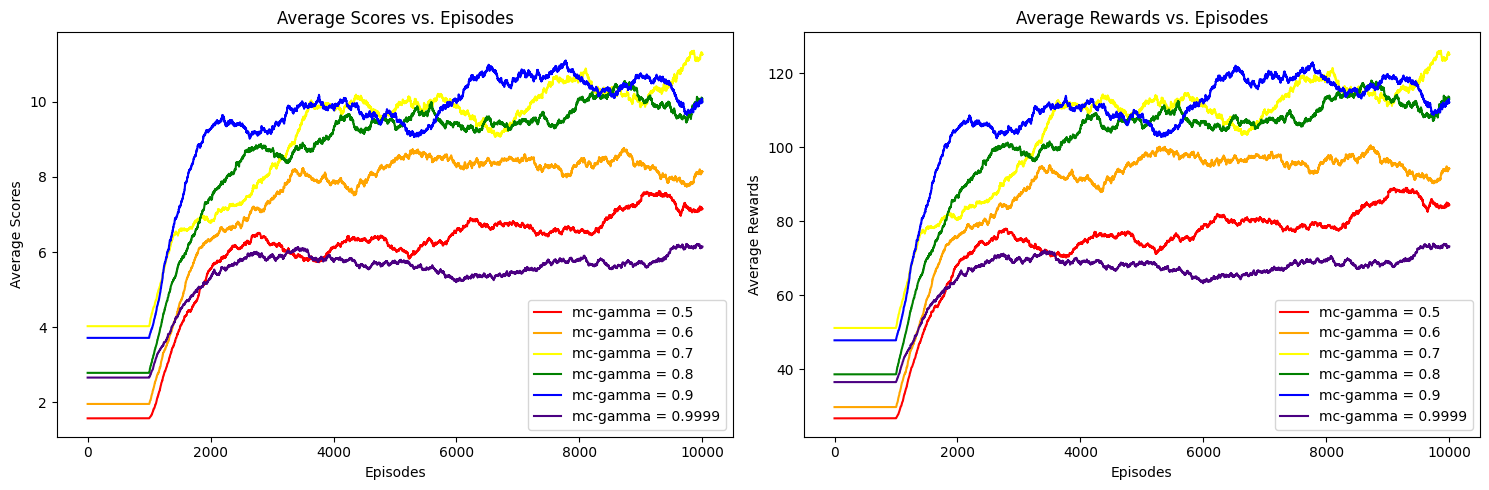

In [124]:
episodes = np.arange(0, 10001, 1)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5)) 

# Đồ thị đầu tiên cho Average Scores
ax1.plot(episodes, average_score_mc_gm_05, label="mc-gamma = 0.5", color="red")
ax1.plot(episodes, average_score_mc_gm_06, label="mc-gamma = 0.6", color="orange")
ax1.plot(episodes, average_score_mc_gm_07, label="mc-gamma = 0.7", color="yellow")
ax1.plot(episodes, average_score_mc_gm_08, label="mc-gamma = 0.8", color="green")
ax1.plot(episodes, average_score_mc_gm_09, label="mc-gamma = 0.9", color="blue")
ax1.plot(episodes, average_score_mc_gm_09999, label="mc-gamma = 0.9999", color="indigo")
ax1.set_xlabel("Episodes")
ax1.set_ylabel("Average Scores")
ax1.legend()
ax1.set_title("Average Scores vs. Episodes")

# Đồ thị thứ hai cho Average Rewards
ax2.plot(episodes, average_reward_mc_gm_05, label="mc-gamma = 0.5", color="red")
ax2.plot(episodes, average_reward_mc_gm_06, label="mc-gamma = 0.6", color="orange")
ax2.plot(episodes, average_reward_mc_gm_07, label="mc-gamma = 0.7", color="yellow")
ax2.plot(episodes, average_reward_mc_gm_08, label="mc-gamma = 0.8", color="green")
ax2.plot(episodes, average_reward_mc_gm_09, label="mc-gamma = 0.9", color="blue")
ax2.plot(episodes, average_reward_mc_gm_09999, label="mc-gamma = 0.9999", color="indigo")
ax2.set_xlabel("Episodes")
ax2.set_ylabel("Average Rewards")
ax2.legend()
ax2.set_title("Average Rewards vs. Episodes")

# Hiển thị cả hai đồ thị trong cùng một khung hình
plt.tight_layout()  # Điều chỉnh khoảng cách giữa các đồ thị
plt.show()


100%|██████████| 10000/10000 [00:12<00:00, 795.67it/s]


Average reward over 10000 train episodes: 53.82528252825283
Median reward over 10000 train episodes: 33.0
Average scores over 10000 train episodes: 4.273627362736273
Median scores over 10000 train episodes: 2.0


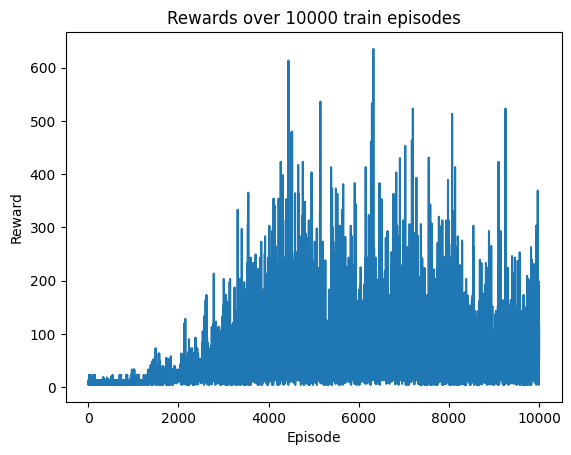

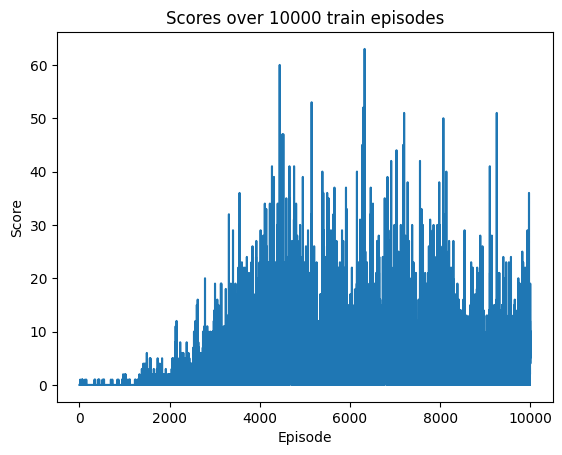

In [14]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)


n_episodes = 10000
# create the Q_learning agent
Q_agent = QLearningAgent(num_actions=2,epsilon=0.1,eps_decay=1,step_size=0.7,step_size_decay=1,discount=1,seed=0)

# train the Q_learning agent
train_rewards, train_scores = Q_agent.train(env,n_episodes)

print(f"Average reward over {n_episodes} train episodes:", np.mean(train_rewards))
print(f"Median reward over {n_episodes} train episodes:", np.median(train_rewards))
print(f"Average scores over {n_episodes} train episodes:", np.mean(train_scores))
print(f"Median scores over {n_episodes} train episodes:", np.median(train_scores))


# plot the rewards
plt.plot(train_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title(f"Rewards over {n_episodes} train episodes")
plt.show()

# plot the scores
plt.plot(train_scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title(f"Scores over {n_episodes} train episodes")
plt.show()

  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [02:58<00:00, 111.79it/s]


Average reward over 20000 train episodes: 345.67143357167856
Median reward over 20000 train episodes: 203.0
Average scores over 20000 train episodes: 33.35636781839092
Median scores over 20000 train episodes: 19.0


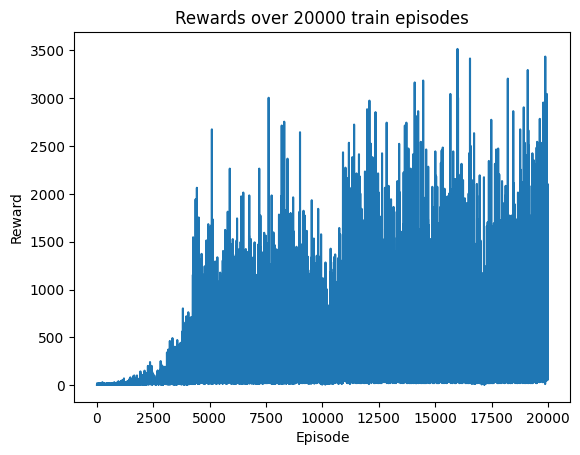

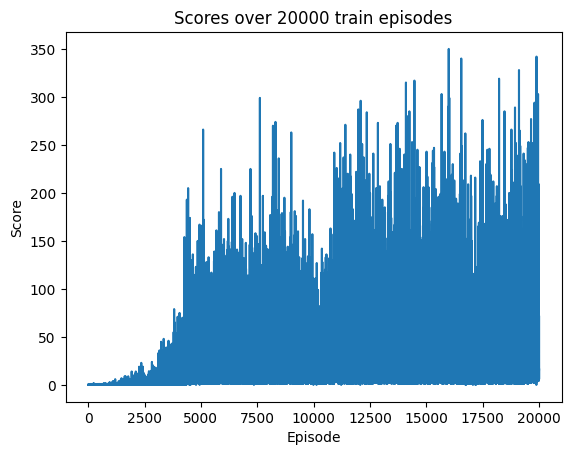

In [15]:
agent = QLearningAgent(num_actions=2,epsilon=0.1,eps_decay=0.99999,step_size=0.5,step_size_decay=1,discount=1,seed=0)

env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
n_episodes=20000
# train the QLearning agent
train_rewards, train_scores = agent.train(env,n_episodes)

print(f"Average reward over {n_episodes} train episodes:", np.mean(train_rewards))
print(f"Median reward over {n_episodes} train episodes:", np.median(train_rewards))
print(f"Average scores over {n_episodes} train episodes:", np.mean(train_scores))
print(f"Median scores over {n_episodes} train episodes:", np.median(train_scores))


# plot the rewards
plt.plot(train_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title(f"Rewards over {n_episodes} train episodes")
plt.show()

# plot the scores
plt.plot(train_scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title(f"Scores over {n_episodes} train episodes")
plt.show()

100%|██████████| 100/100 [00:00<00:00, 113.84it/s]


Average reward over 100 test episodes: 529.4
Median reward over 100 test episodes: 413.0
Average scores over 100 test episodes: 51.64
Median scores over 100 test episodes: 40.0


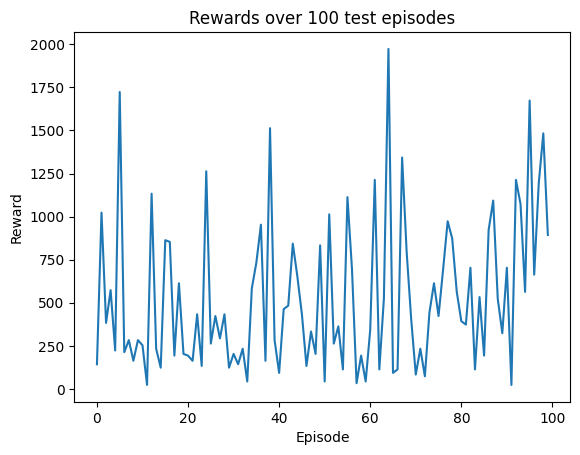

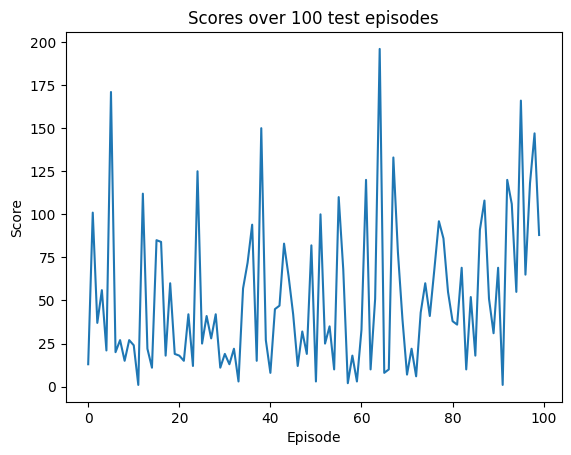

In [16]:
# test the trained agent for 100 episodes
n_episodes=100
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
test_rewards,test_scores = agent.test(env,n_episodes=n_episodes)
print(f"Average reward over {n_episodes} test episodes:", np.mean(test_rewards))
print(f"Median reward over {n_episodes} test episodes:", np.median(test_rewards))
print(f"Average scores over {n_episodes} test episodes:", np.mean(test_scores))
print(f"Median scores over {n_episodes} test episodes:", np.median(test_scores))


# plot the rewards
plt.plot(test_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title(f"Rewards over {n_episodes} test episodes")
plt.show()

# plot the scores
plt.plot(test_scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title(f"Scores over {n_episodes} test episodes")
plt.show()

In [17]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
agent.run(env)

Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[      @           | ]
[                    ]
[                    ]
[                    ]
[                    ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=12,dy=-3)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[      @          |  ]
[                 |  ]
[                    ]
[                    ]
[                    ]
[                    ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=11,dy=-4)
Text Flappy Bird!
Score: 0
----------------------
[     

49